In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(crayon)
    library(tidyverse)
}))

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    prj_path = "/home/vsevim/prj/1012-ckd/S1/"
    data_subdir = "/analysis/primary/cellranger/Screen1_66guides_L1/outs/"
    souporcell_clusters_path = "/home/vsevim/prj/1012-ckd/S1/analysis/primary/souporcell/Lib_1/clusters.tsv"
    seurat_obj_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/Lib_1/seurat_objects/"
    seurat_obj_fname = "Screen1_66guides_Lib_1.h5seurat"

    library_name = "Lib_1"
    save_seurat_h5 = "NO"

    prj_name    = "Screen2_101vecs"
    prj_path    = "/home/vsevim/prj/1012-ckd/S2/"
    data_subdir = "/analysis/primary/cellranger/Screen2_101vecs_1/outs/"
    souporcell_clusters_path = "/home/vsevim/prj/1012-ckd/S2/analysis/primary/souporcell/Lib_1/clusters.tsv"
    seurat_obj_path  = "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/Lib_1/seurat_objects/"
    seurat_obj_fname = "Screen2_101vecs_Lib_1.h5seurat"

    library_name = "Lib_1"
    save_seurat_h5 = "NO"
}

In [4]:
data_path <- paste0(prj_path, data_subdir)
mx_path   <- paste0(data_path, "/filtered_feature_bc_matrix/")
h5_path   <- paste0(data_path, "/filtered_feature_bc_matrix.h5")
umi_thresholds_path <- paste0(data_path, "/crispr_analysis/protospacer_umi_thresholds.csv")
ps_calls_path <- paste0(data_path, "/crispr_analysis/protospacer_calls_per_cell.csv")
stats_out_path <- paste0(prj_path, "/analysis/primary/stats/")
save_h5_file <- paste0(seurat_obj_path, seurat_obj_fname)

In [5]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

In [6]:
data_path

[1] "/home/vsevim/prj/1012-ckd/S2//analysis/primary/cellranger/Screen2_101vecs_1/outs/"

In [7]:
if(!file.exists(souporcell_clusters_path)){    
    cat(souporcell_clusters_path, "DOES NOT EXIST!")
    stopifnot(FALSE)
}

### Load cell-cycle data

In [8]:
# A list of cell cycle markers, from Tirosh et al, 2015, is loaded with Seurat.  We can
# segregate this list into markers of G2/M phase and markers of S phase
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes


### Import demux counts from Cellranger

In [9]:
df_thresholds = read.csv(umi_thresholds_path)
df_ps_calls   = read.csv(ps_calls_path)

### Load 10x data

In [10]:
inputdata   <- Read10X_h5(h5_path)

Genome matrix has multiple modalities, returning a list of matrices for this genome



In [11]:
# extract RNA and sgRNA data
rna_counts   <- inputdata$`Gene Expression`
sgrna_counts <- inputdata$`CRISPR Guide Capture`

In [12]:
dim(rna_counts)
dim(sgrna_counts)

[1] 36601  5634

[1]  202 5634

In [13]:
n_cells_from_cellranger = ncol(rna_counts)
n_protospacers = nrow(sgrna_counts)
all_protospacer_ids = colnames(sgrna_counts)
n_genes = sum(rowSums(rna_counts) > 0)
cat(blue(prj_name, library_name), "\n")
cat(blue("#cells recovered:", n_cells_from_cellranger), "\n")
cat(blue("#genes recovered:", n_genes), "\n")
cat(blue("#protospacers in assay:", n_protospacers), "\n")

stats[["Screen"]]                = prj_name 
stats[["Library"]]               = library_name
stats[["Cells recovered"]]       = n_cells_from_cellranger
stats[["Genes recovered"]]       = n_genes
stats[["Protospacers in assay"]] = n_protospacers

Screen2_101vecs Lib_1 
#cells recovered: 5634 
#genes recovered: 29924 
#protospacers in assay: 202 


# Visualize protospacer counts

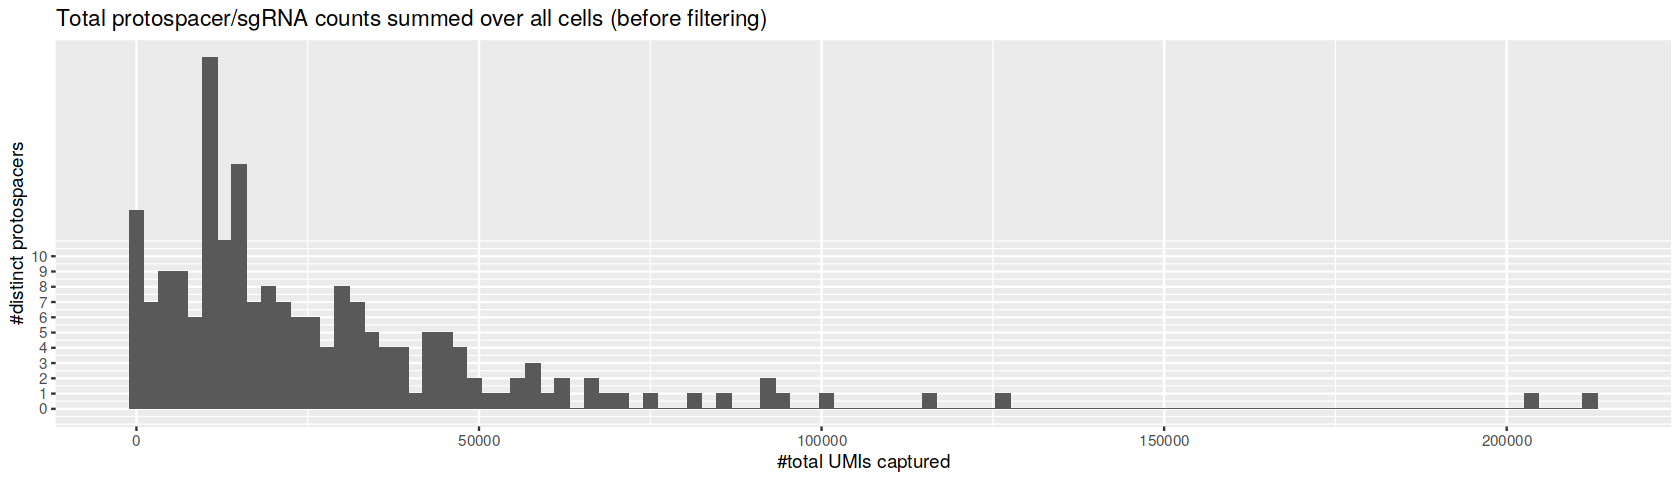

In [14]:
df_guide_counts = data.frame(total_guide_count=rowSums(sgrna_counts))
row.names(df_guide_counts) <- row.names(sgrna_counts)

options(repr.plot.width=14, repr.plot.height=4)
ggplot(df_guide_counts, aes(x = total_guide_count)) +
    geom_histogram(bins=100) +
    labs(title = "Total protospacer/sgRNA counts summed over all cells (before filtering)", x = "#total UMIs captured") +
    labs(y = "#distinct protospacers") +
    scale_y_continuous(breaks=seq(0,10, by=1))


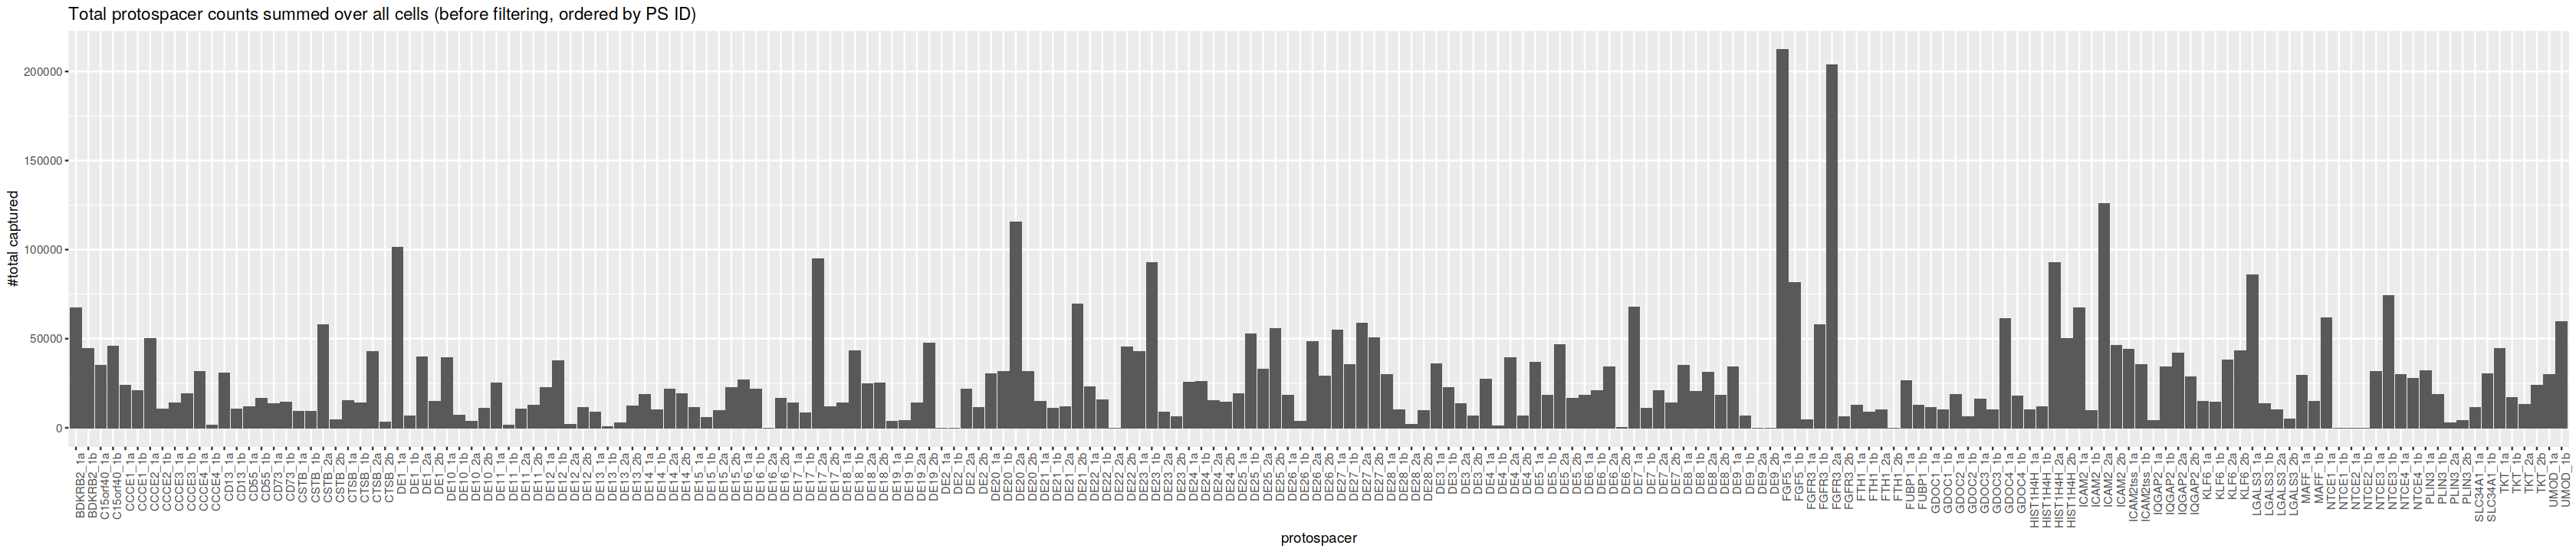

In [15]:
df_guide_counts_ordered <- df_guide_counts[order(df_guide_counts$total_guide_count),,drop=FALSE]
df_guide_counts_ordered$protospacer  <- rownames(df_guide_counts_ordered)

options(repr.plot.width=28, repr.plot.height=6)
ggplot(df_guide_counts_ordered, aes(x=protospacer, y=total_guide_count)) +
    geom_bar(stat='identity') + 
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(title = "Total protospacer counts summed over all cells (before filtering, ordered by PS ID)", x = "protospacer") +
    labs(y = "#total captured") 

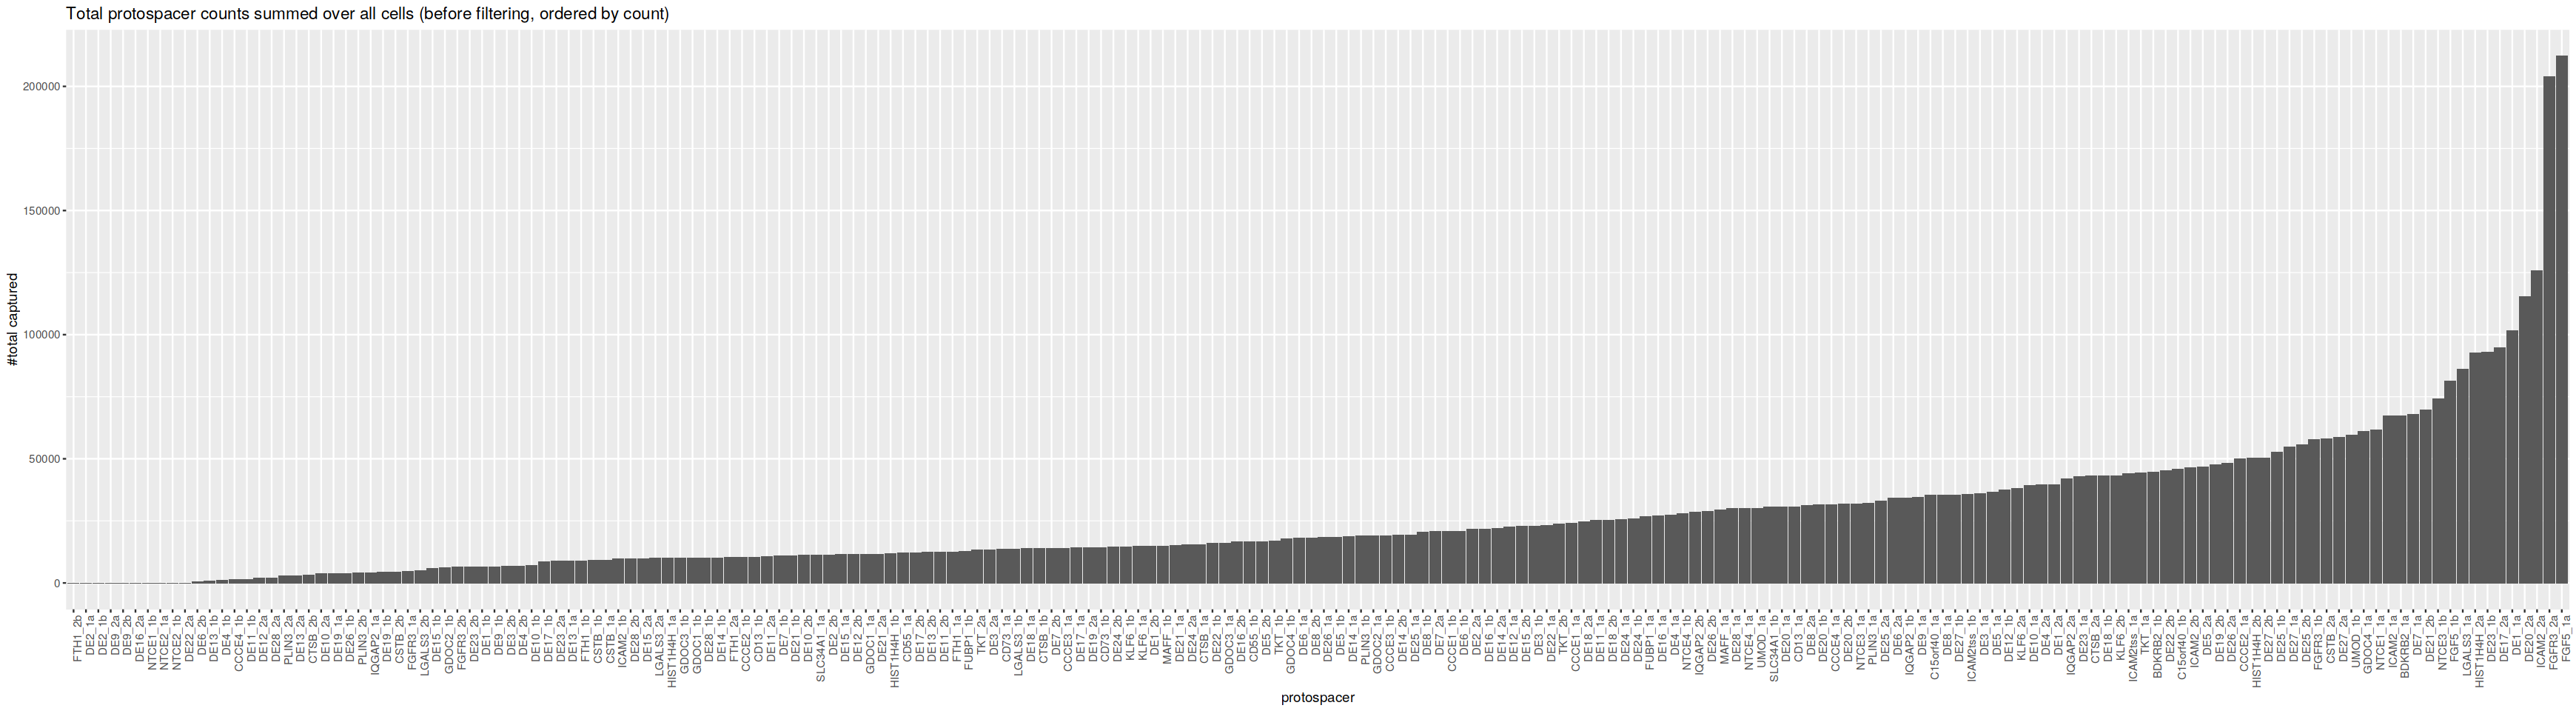

In [16]:
df_guide_counts_ordered$protospacer <- factor(df_guide_counts_ordered$protospacer, levels = df_guide_counts_ordered$protospacer)

options(repr.plot.width=29, repr.plot.height=8)
ggplot(df_guide_counts_ordered, aes(x=protospacer, y=total_guide_count)) +
    geom_bar(stat='identity') + 
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(title = "Total protospacer counts summed over all cells (before filtering, ordered by count)", x = "protospacer") +
    labs(y = "#total captured") 

In [17]:
head(df_guide_counts_ordered,10)

total_guide_count protospacer
FTH1_2b  0                 FTH1_2b    
DE2_1a   0                 DE2_1a     
DE2_1b   0                 DE2_1b     
DE9_2a   0                 DE9_2a     
DE9_2b   0                 DE9_2b     
DE16_2a  0                 DE16_2a    
NTCE1_1b 0                 NTCE1_1b   
NTCE2_1a 0                 NTCE2_1a   
NTCE2_1b 0                 NTCE2_1b   
DE22_2a  0                 DE22_2a

### Create Seurat object

In [18]:
seurat_unfiltered <- CreateSeuratObject(counts = rna_counts, project = prj_name)
sgrna_assay       <- CreateAssayObject(counts = sgrna_counts)
seurat_unfiltered[["sgRNA"]] <- sgrna_assay
seurat_unfiltered$library = library_name

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


### Get mitochondrial content

In [19]:
seurat_unfiltered[["percent.mt"]] <-
    PercentageFeatureSet(seurat_unfiltered, pattern = "^MT-")

In [20]:
DefaultAssay(seurat_unfiltered) <- "RNA"

## QC

### Get RNA counts per cell

In [21]:
counts_per_cell <- Matrix::colSums(rna_counts)
cat("counts per cell: ", counts_per_cell[1:20], "\n") ## counts for first 5 cells

counts per cell:  30002 11208 24316 33470 21181 28296 20007 16118 18470 65072 37894 25046 54070 40333 27920 28746 2570 38302 62531 22054 


In [22]:
counts_per_gene <- Matrix::rowSums(rna_counts)
cat("counts per gene: ", counts_per_gene[1:20], "\n")  

counts per gene:  1 0 4 52 3 1 93 0 2 0 0 0 0 1 838 5 1297 107 144 22 


In [23]:
genes_per_cell  <- Matrix::colSums(rna_counts > 0)       # count gene only if it has non-zero reads mapped.
guides_per_cell <- Matrix::colSums(sgrna_counts > 0)     # count gene only if it has non-zero reads mapped.

cat("counts for non-zero genes: ", genes_per_cell[1:5], "\n")  # counts for first 5 genes
cat("counts for non-zero guides:", guides_per_cell[1:5], "\n")  # counts for first 5 genes

counts for non-zero genes:  6588 3680 6019 7415 5623 
counts for non-zero guides: 11 11 11 6 8 


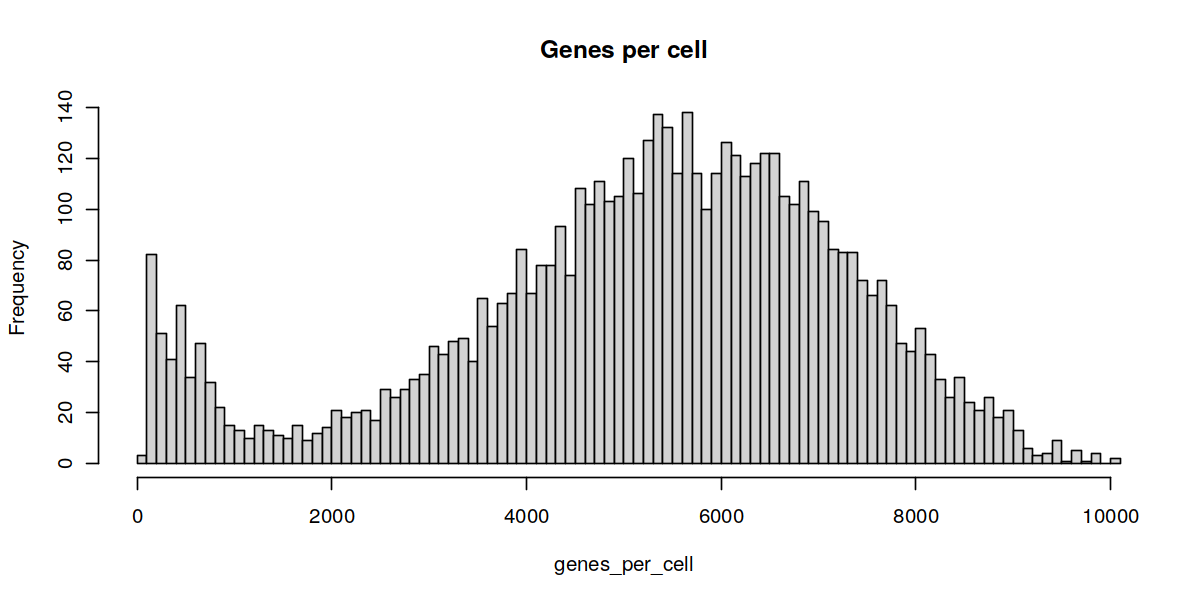

In [24]:
options(repr.plot.width=10, repr.plot.height=5)
#plot_log <- hist(log10(genes_per_cell), main="Genes per cell", breaks=100)
plot_lin <- hist(genes_per_cell, main="Genes per cell", breaks=100, xlim=c(1,10000))
#plot_guide_counts <- hist(guides_per_cell, main="Distinct protospacers per cell", breaks=100, xlim=c(1,100))

### --

### Plot RNA counts per cell 

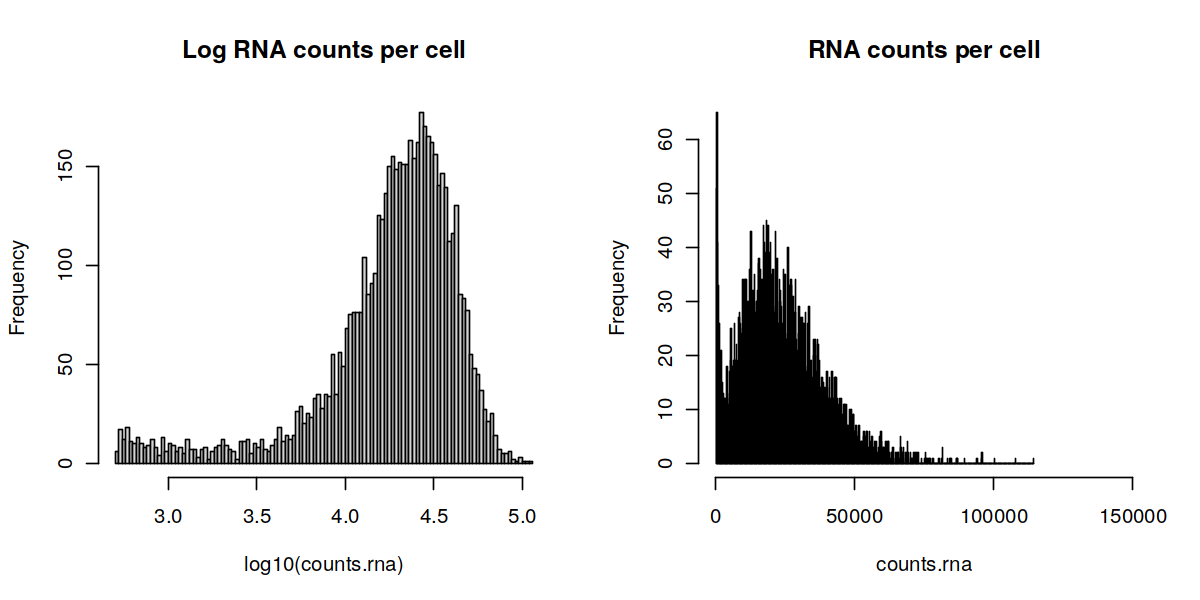

In [25]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
counts.rna <- seurat_unfiltered@meta.data$nCount_RNA
plot_log    <- hist(log10(counts.rna), main="Log RNA counts per cell", breaks=100)
plot_lin    <- hist(counts.rna, main="RNA counts per cell", breaks=500, xlim=c(1,150000))

### Plot sgRNA counts per cell 

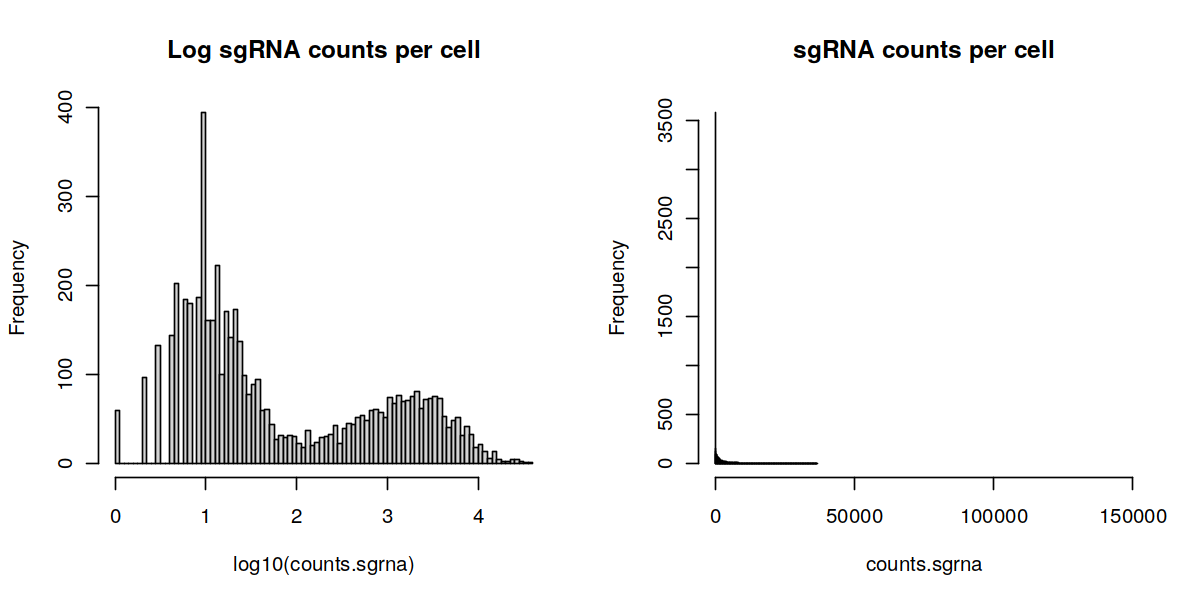

In [26]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
counts.sgrna <- seurat_unfiltered@meta.data$nCount_sgRNA
plot_log    <- hist(log10(counts.sgrna), main="Log sgRNA counts per cell", breaks=100)
plot_lin    <- hist(counts.sgrna, main="sgRNA counts per cell", breaks=500, xlim=c(1,150000))

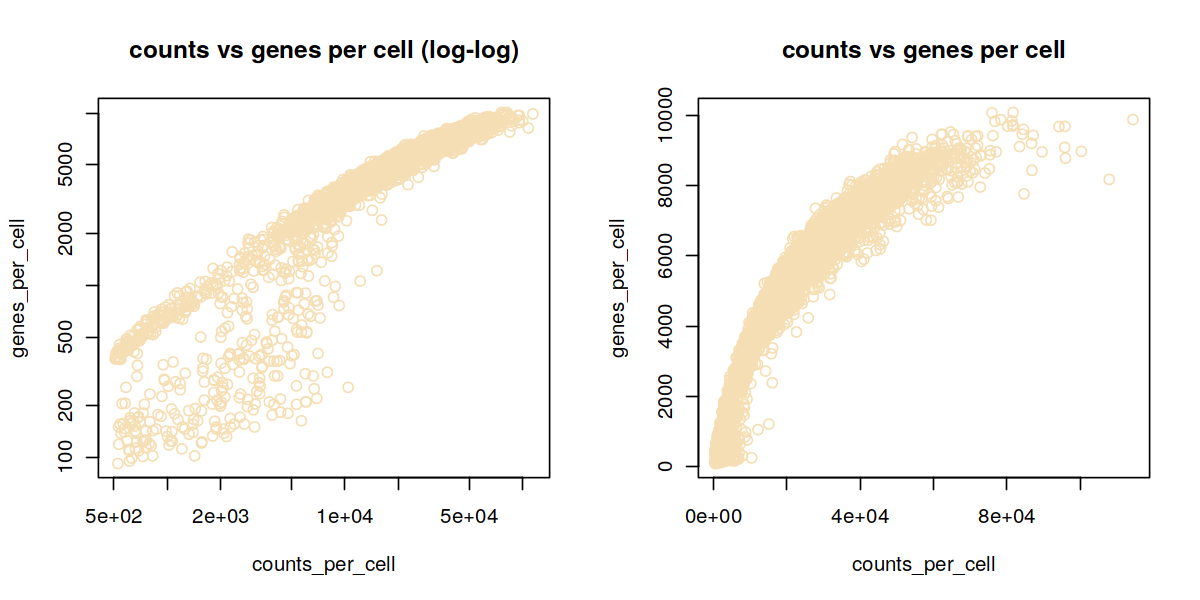

In [27]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
plot(counts_per_cell, genes_per_cell, log='xy', col='wheat')
title('counts vs genes per cell (log-log)')
plot(counts_per_cell, genes_per_cell, col='wheat')
title('counts vs genes per cell')

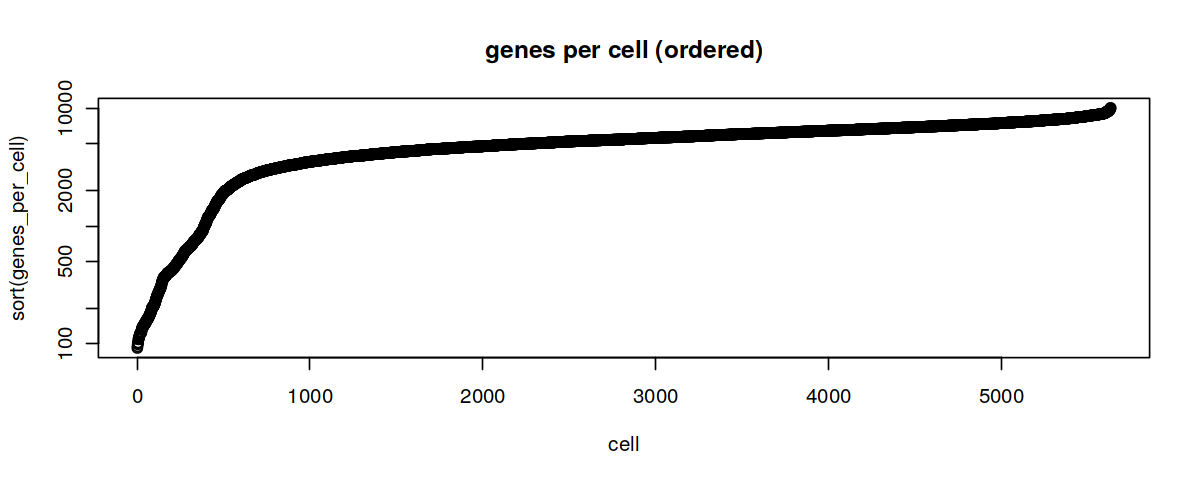

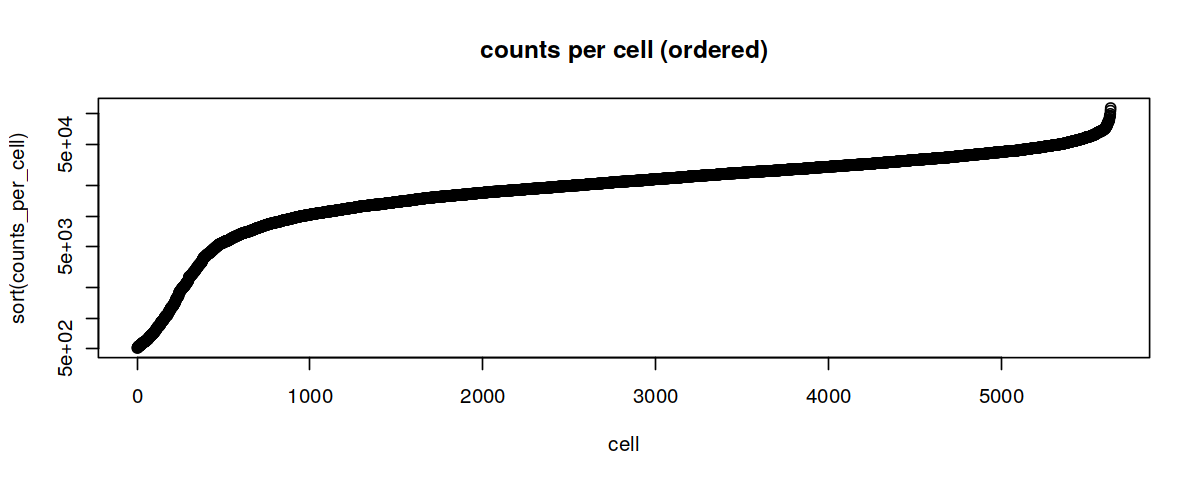

In [28]:
options(repr.plot.width=10, repr.plot.height=4)
plot(sort(genes_per_cell), xlab='cell', log='y', main='genes per cell (ordered)')
plot(sort(counts_per_cell), xlab='cell', log='y', main='counts per cell (ordered)')

In [29]:
#FeatureScatter(object = seurat_unfiltered, feature1 = "nCount_RNA", feature2 = "nCount_ATAC", log)

### QC using houskeeping genes

In [30]:
# Load the the list of house keeping genes
hkgenes <- read.table("/home/vsevim/prj/tf/tf1/data/QC/housekeeping.txt", skip = 2)
hkgenes <- as.vector(hkgenes$V1)

In [31]:
# remove hkgenes that were not found
hkgenes.found <- which(toupper(rownames(seurat_unfiltered@assays$RNA@data)) %in% hkgenes)

In [32]:
num_hk_genes = length(hkgenes.found)
num_hk_genes

[1] 95

In [33]:
n.expressed.hkgenes <- Matrix::colSums(seurat_unfiltered@assays$RNA@data[hkgenes.found, ] > 0)

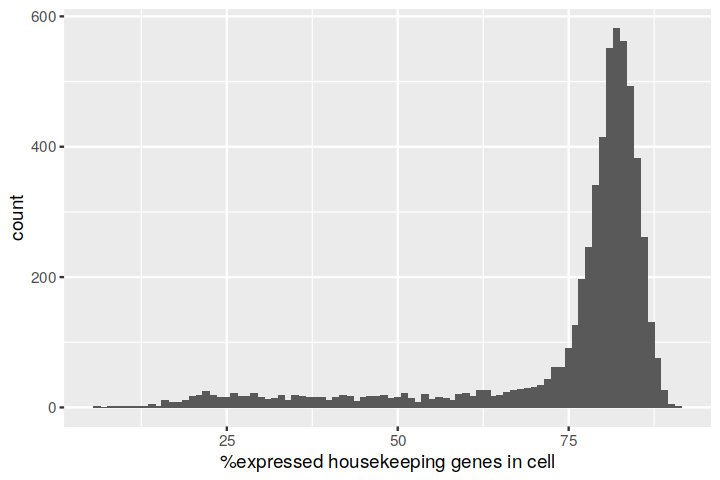

In [34]:
options(repr.plot.width=6, repr.plot.height=4)
df.expressed.hk <- data.frame(100*n.expressed.hkgenes/num_hk_genes)
ggplot(df.expressed.hk, aes(n.expressed.hkgenes)) + geom_histogram(binwidth=1) + labs(x="%expressed housekeeping genes in cell")

### QC by mitochondrial genes

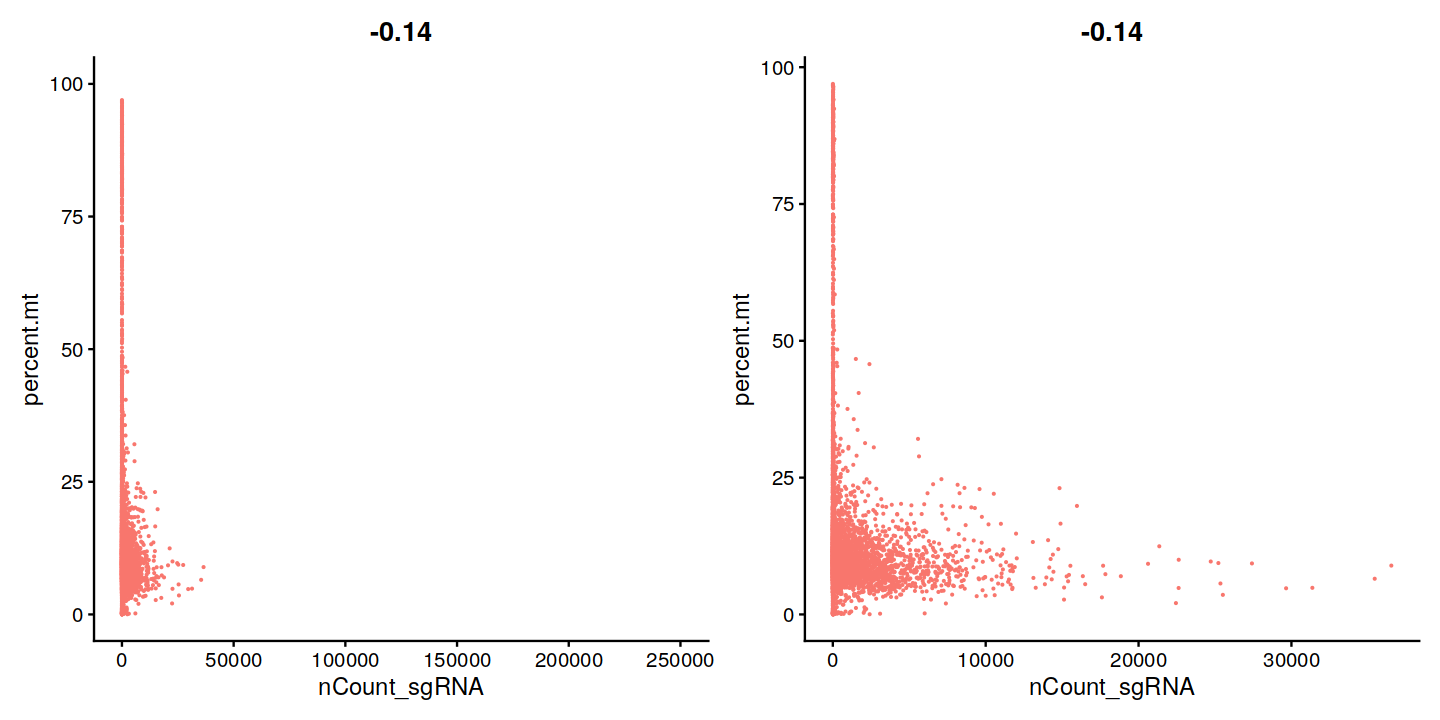

In [35]:
options(repr.plot.width=12, repr.plot.height=6)
plot1 <- FeatureScatter(seurat_unfiltered, feature1 = "nCount_sgRNA", feature2 = "percent.mt", pt.size=.1)
plot1 + xlim(c(0,250000)) + ylim(c(0,100)) + NoLegend() | plot1 + NoLegend()

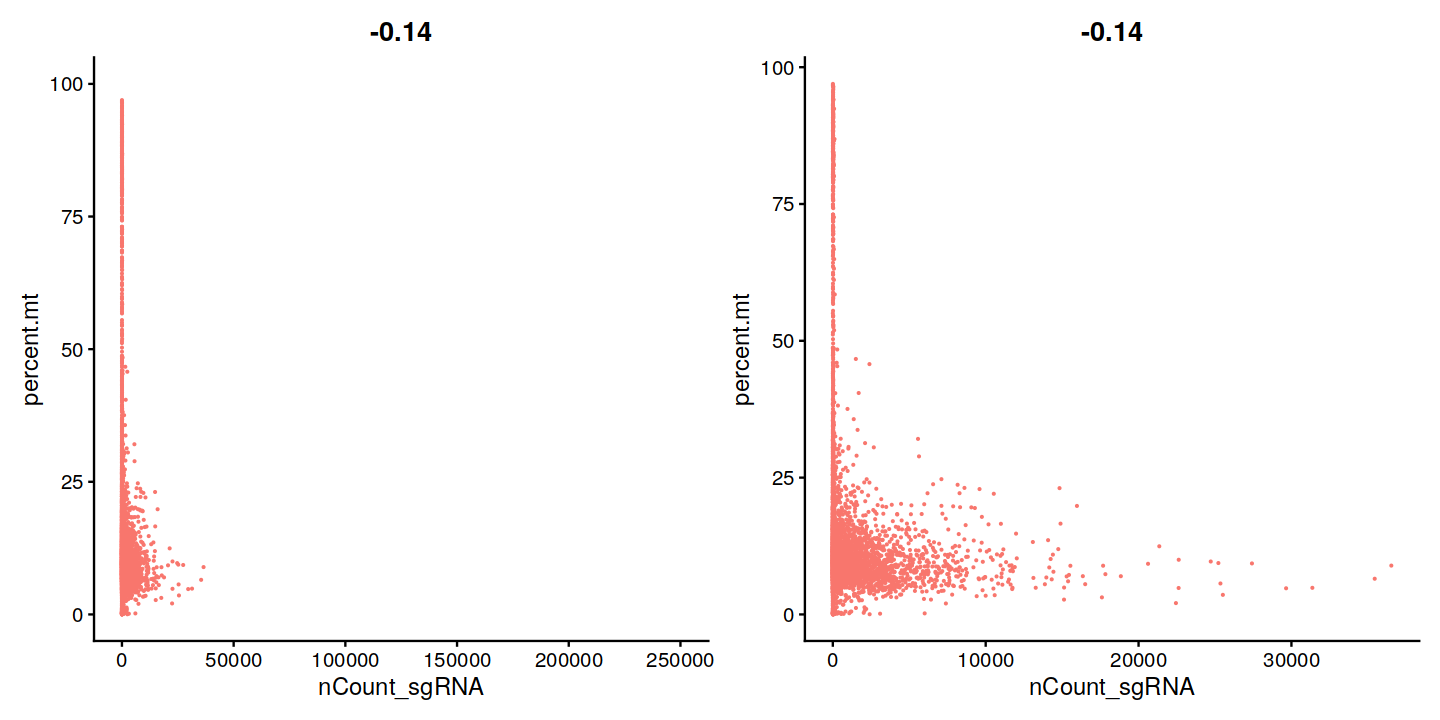

In [36]:
options(repr.plot.width=12, repr.plot.height=6)
plot1 <- FeatureScatter(seurat_unfiltered, feature1 = "nCount_sgRNA", feature2 = "percent.mt", pt.size=.1)
plot1 + xlim(c(0,250000)) + ylim(c(0,100)) + NoLegend() | plot1 + NoLegend()

## Filtering

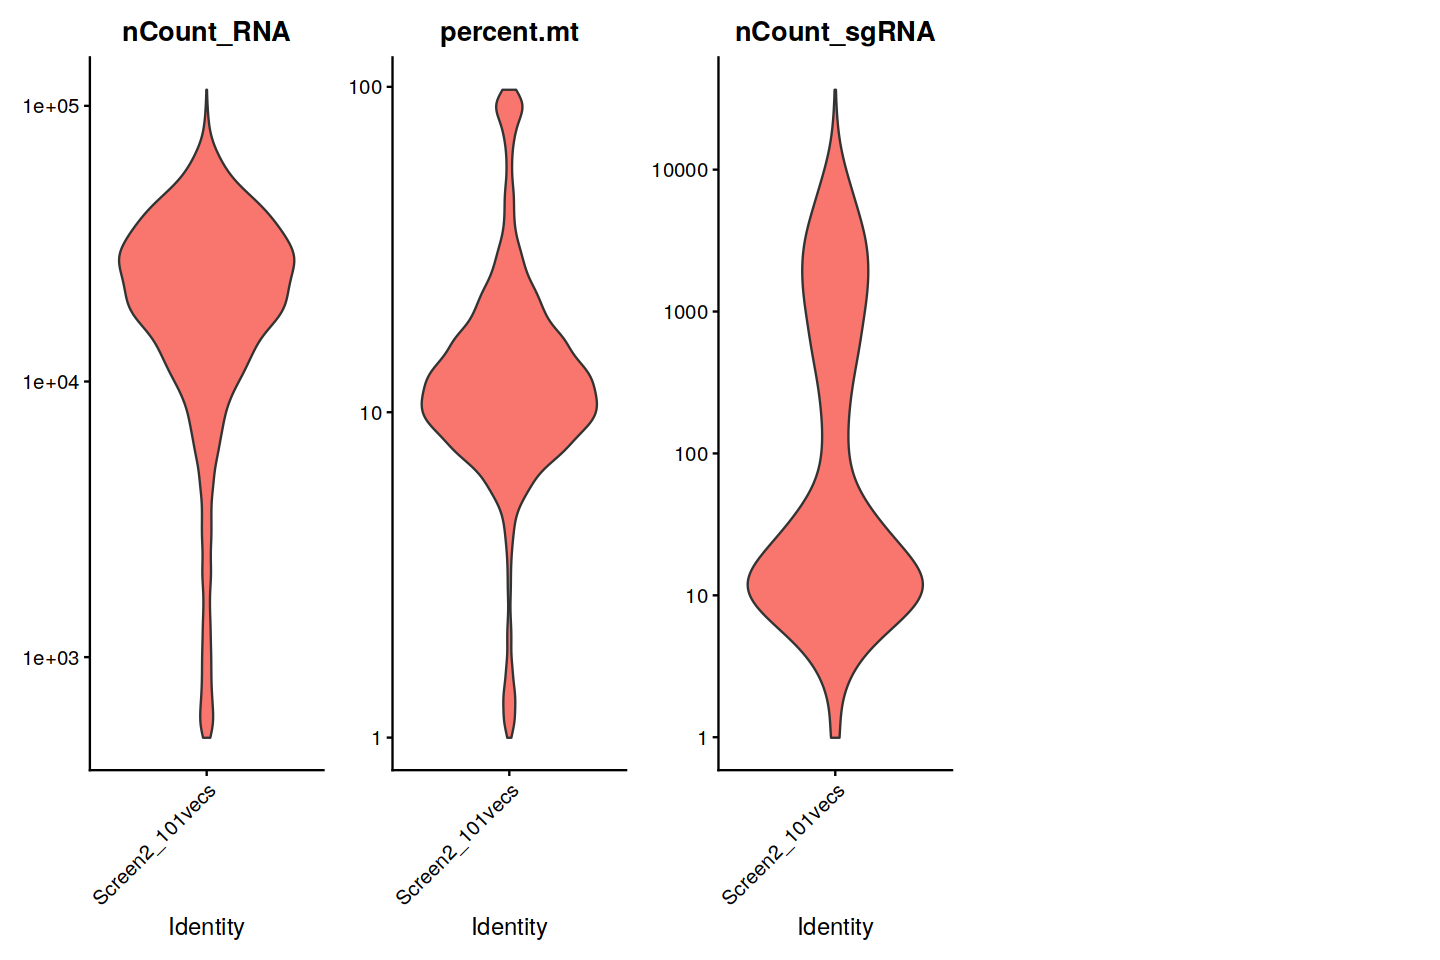

In [37]:
options(repr.plot.width=12, repr.plot.height=8)

VlnPlot(
  object = seurat_unfiltered,
  features = c("nCount_RNA", "percent.mt", "nCount_sgRNA"),
  ncol = 5,
  log=TRUE,
  pt.size = 0
)

### Filter out low quality cells

In [38]:
seurat <- subset(
  x = seurat_unfiltered,
  subset = nCount_RNA < 170000 &
    nCount_RNA > 6000 &
    percent.mt < 20 
)


In [39]:
stats[["Cells after QC filtering"]] <- length(Cells(seurat))
stats[["Cells with sgRNA count < 100"]] <- length(Cells(subset(x = seurat, subset = nCount_sgRNA < 100)))

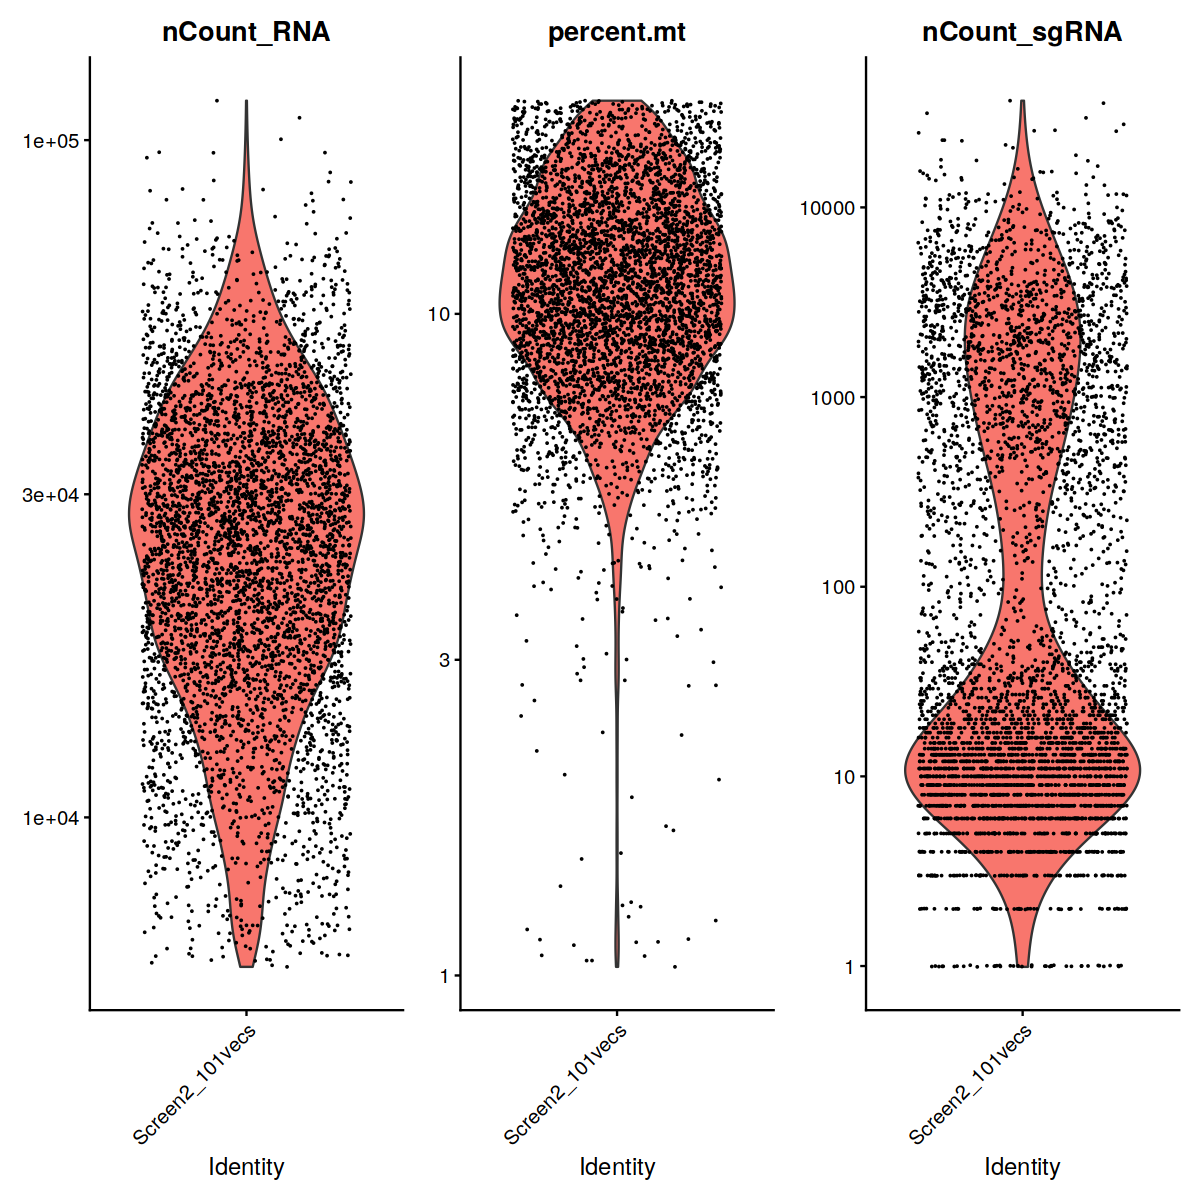

In [40]:
options(repr.plot.width=10, repr.plot.height=10)
VlnPlot(seurat, 
        features = c("nCount_RNA", "percent.mt", "nCount_sgRNA"), 
        ncol = 3, 
        log = TRUE, 
        pt.size = .01)

In [41]:
remaining_cells <- nrow(seurat@meta.data)
remaining_cells

[1] 4498

### Import demux counts from Cellranger

In [42]:
df_thresholds = read.csv(umi_thresholds_path)
df_ps_calls   = read.csv(ps_calls_path)

In [43]:
guide_calls_list         = list()
construct_calls_list     = vector()
target_calls_list          = list() 
num_construct_calls_list = list()
num_guide_calls_list     = list()

for(call in df_ps_calls$feature_call) {
    calls <- strsplit(call, "\\|")[[1]]
    guide_calls <- calls
    
    calls <- gsub("_1.", "_1", calls)
    calls <- gsub("_2.", "_2", calls)
    calls <- unique(calls)
    target_calls <- paste(unique(gsub("_[0-9]*", "", calls)), collapse = "|")

    target_calls_list        <- c(target_calls_list, target_calls)
    construct_calls_list     <- c(construct_calls_list, paste(calls, collapse = "|"))
    num_construct_calls_list <- c(num_construct_calls_list, length(calls))
    guide_calls_list         <- c(guide_calls_list, list(guide_calls))
    num_guide_calls_list     <- c(num_guide_calls_list, length(guide_calls))
}
df_ps_calls$construct_call        <- as.factor(as.character(construct_calls_list))
df_ps_calls$num_called_constructs <- num_construct_calls_list
df_ps_calls$PS_call               <- guide_calls_list
df_ps_calls$num_PS_call           <- num_guide_calls_list
df_ps_calls$target_call           <- as.character(target_calls_list)

In [44]:
head(calls, 10)
head(target_calls)

[1] "UMOD_1"

[1] "UMOD"

In [45]:
head(df_ps_calls$target_call, 100)

[1] "BDKRB2"                                                                                                                                                    
  [2] "BDKRB2"                                                                                                                                                    
  [3] "BDKRB2"                                                                                                                                                    
  [4] "BDKRB2"                                                                                                                                                    
  [5] "BDKRB2|DE20|ICAM2tss"                                                                                                                                      
  [6] "BDKRB2|ICAM2"                                                                                                                                              
  [7] "BDKRB2|IQGAP2"                                                                                                                                             
  [8] "C15orf40"                                                                                                                                                  
  [9] "C15orf40"                                                                                                                                                  
 [10] "C15orf40"                                                                                                                                                  
 [11] "C15orf40|CSTB|DE1|DE2|DE3|DE5|DE17|NTCE4|CCCE2|DE20|DE21|DE26|DE27|IQGAP2|DE18"                                                                            
 [12] "C15orf40|DE10|DE19|DE27"                                                                                                                                   
 [13] "C15orf40|DE10|DE12|NTCE3|DE18|DE20|DE26|DE27|DE19|DE25"                                                                                                    
 [14] "C15orf40|DE17|CCCE4|DE23|IQGAP2|HIST1H4H|SLC34A1|DE18|FGFR3"                                                                                               
 [15] "C15orf40|DE17|NTCE1|BDKRB2|ICAM2tss|DE25|HIST1H4H"                                                                                                         
 [16] "C15orf40|DE1|DE20|DE26"                                                                                                                                    
 [17] "C15orf40|DE20|DE26|DE27"                                                                                                                                   
 [18] "C15orf40|DE20"                                                                                                                                             
 [19] "C15orf40|DE2|DE15|DE22|DE24|DE26|DE27|ICAM2tss|BDKRB2"                                                                                                     
 [20] "C15orf40|DE6|DE7|DE12|CCCE3"                                                                                                                               
 [21] "C15orf40|FTH1|DE16|NTCE1|DE27|DE21"                                                                                                                        
 [22] "C15orf40|FTH1|PLIN3|DE1|DE2|DE3|DE10|DE13|DE14|DE16|NTCE3|GDOC2|GDOC4|DE18|DE19|DE21|DE22|DE24|DE26|DE27|DE28|FGFR3|HIST1H4H|ICAM2|SLC34A1|BDKRB2|ICAM2tss"
 [23] "C15orf40|FTH1|CSTB|DE8|DE17|NTCE3|DE20|DE27|DE28|IQGAP2|HIST1H4H|SLC34A1|FGFR3|FGF5"                                                                       
 [24] "C15orf40|FTH1|DE13|DE14|DE21|DE27|DE28|IQGAP2|SLC34A1"                                                                                                     
 [25] "C15orf40|FTH1|KLF6|DE3|CCCE4|DE18|DE20"                                            

<font color='red'>Keep only the cells with PS calls from Cellranger (skip this if you switch to another demux algo)</font> !!!!


In [46]:
cells_w_PS_calls <- df_ps_calls$cell_barcode
seurat <- subset(seurat, cells = cells_w_PS_calls)
stats[["Cells with a guide assigned"]] <- length(Cells(seurat))

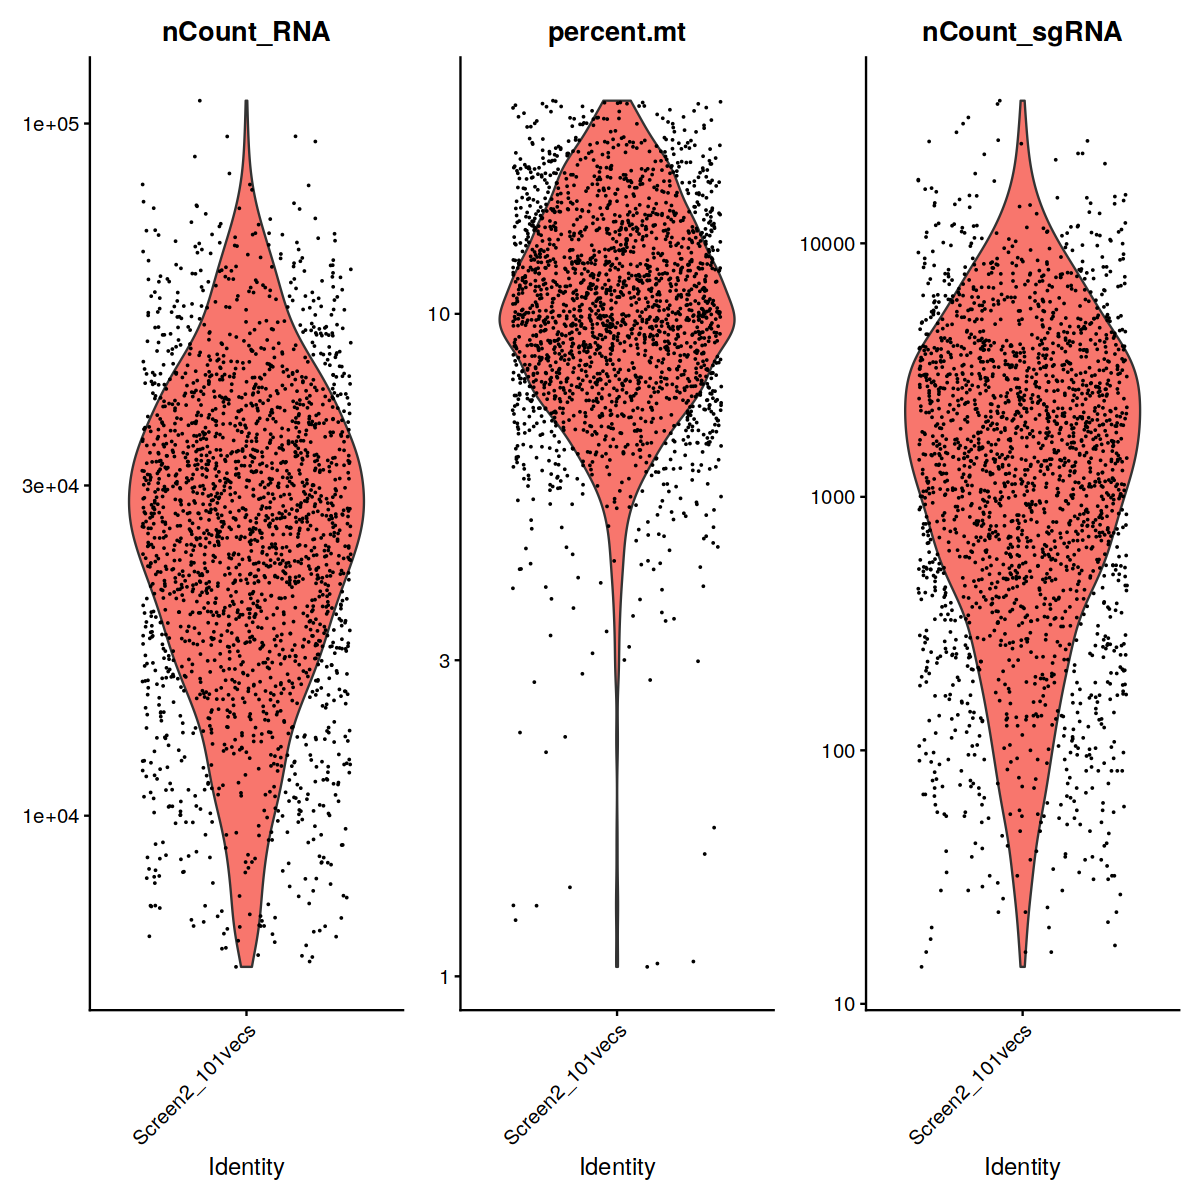

In [47]:
options(repr.plot.width=10, repr.plot.height=10)
VlnPlot(seurat, 
        features = c("nCount_RNA", "percent.mt", "nCount_sgRNA"), 
        ncol = 3, 
        log = TRUE, 
        pt.size = .01)

In [48]:
my_cells = Cells(seurat)
rownames(df_ps_calls) <- df_ps_calls$cell_barcode

df_ps_calls_ordered_by_barcodes = df_ps_calls[my_cells,]

seurat@meta.data$PS_call            <- as.factor(df_ps_calls_ordered_by_barcodes$feature_call)
seurat@meta.data$construct_call     <- as.factor(df_ps_calls_ordered_by_barcodes$construct_call)
seurat@meta.data$target_call        <- as.factor(df_ps_calls_ordered_by_barcodes$target_call)
seurat@meta.data$nCalled_Constructs <- as.integer(df_ps_calls_ordered_by_barcodes$num_called_constructs)
seurat@meta.data$nPS_calls          <- as.integer(df_ps_calls_ordered_by_barcodes$num_PS_call)
seurat@meta.data$nCalled_sgRNA_UMIs <- df_ps_calls_ordered_by_barcodes$num_umis

In [49]:
head(seurat, 3)

orig.ident      nCount_RNA nFeature_RNA nCount_sgRNA
GAAGGACAGAGGTTAT-1 Screen2_101vecs 27923      5964         1128        
GCATTAGAGTAAACTG-1 Screen2_101vecs 11747      4180           99        
GTGTGATCATTGAAGA-1 Screen2_101vecs 22832      5554         1412        
                   nFeature_sgRNA library percent.mt PS_call            
GAAGGACAGAGGTTAT-1  5             Lib_1   15.4       BDKRB2_1a|BDKRB2_1b
GCATTAGAGTAAACTG-1 11             Lib_1   17.3       BDKRB2_1a|BDKRB2_1b
GTGTGATCATTGAAGA-1 11             Lib_1    5.3       BDKRB2_1a|BDKRB2_1b
                   construct_call target_call nCalled_Constructs nPS_calls
GAAGGACAGAGGTTAT-1 BDKRB2_1       BDKRB2      1                  2        
GCATTAGAGTAAACTG-1 BDKRB2_1       BDKRB2      1                  2        
GTGTGATCATTGAAGA-1 BDKRB2_1       BDKRB2      1                  2        
                   nCalled_sgRNA_UMIs
GAAGGACAGAGGTTAT-1 629|496           
GCATTAGAGTAAACTG-1 60|28             
GTGTGATCATTGAAGA-1 859|544

## Normalization, PCA, UMAP, SVD

### Normalize RNA assay

In [50]:
DefaultAssay(seurat) <- "RNA"
seurat <- SCTransform(
    seurat, 
    method = "glmGamPoi", 
    vst.flavor = "v2", 
    verbose = FALSE
)  %>% 
    RunPCA() %>% 
    RunUMAP(dims = 1:40, reduction.name = 'umap.rna', reduction.key = 'rnaUMAP_', verbose=FALSE)
 
#RunPCA(features = c(s.genes, g2m.genes)) %>% 
#vars.to.regress = c('S.Score', 'G2M.Score')
#vars.to.regress = "percent.mt", 


PC_ 1 
Positive:  MALAT1, AC079352.1, NEAT1, NRXN3, NLGN1, TRABD2B, PDE4D, KCNQ1OT1, GPC6, FTX 
	   LINC01320, OXR1, DSCAML1, ADAMTS9-AS2, PTPRM, MAGI2, FHIT, LINC01781, NRG3, LRMDA 
	   ZBTB20, DLG2, RIMS2, BNC2, AC008014.1, GBE1, MAML2, MBD5, PTPRG, LINC00511 
Negative:  S100A6, RPS12, LGALS1, RPL10, RPL26, TMSB10, VIM, RPL17, RPS27A, RPS2 
	   RPL41, RPS3A, RPS4X, KRT19, RPL11, RPL7A, S100A11, RPL21, TMSB4X, RPS14 
	   RPS18, S100A10, RPL18A, RPS3, RPL12, RPL8, RPL10A, ANXA2, ACTG1, GAPDH 
PC_ 2 
Positive:  KCNIP4, MECOM, ERBB4, WFDC2, MAL, MUC1, BST2, PDE1A, S100A2, SLPI 
	   PANTR1, GPNMB, TFAP2B, PDLIM4, TFCP2L1, KRT19, LINC01503, AC019197.1, ACSL4, CD9 
	   LRP1B, FAM155A, IRX2, SKAP1, ARHGEF38, KITLG, PLCB1, KRT7, SIM2, DENND2A 
Negative:  APOE, CRYAB, SERPINE2, FN1, VCAM1, CDH6, VGF, HMGA2, SERPINE1, S100A1 
	   TFPI2, AC003092.1, AK5, CTSB, MT1E, FTL, AMACR, MGST1, ANPEP, SOD2 
	   PLIN2, RARRES2, KCNJ15, ARG2, SLC4A4, ABLIM3, SCEL, MT1X, GDA, SLC2A9 
PC_ 3 
Positive:  SERPIN

### Normalize sgRNA counts

In [51]:
seurat <- NormalizeData(
    seurat,
    assay = "sgRNA",
    normalization.method = "CLR"
)

Normalizing across features



Save to Seurat H5

In [52]:
if(save_seurat_h5 == "YES") {
    print("Saving h5...")
    SaveH5Seurat(seurat, filename=save_h5_file, overwrite=TRUE, verbose=FALSE)
}

In [53]:
head(seurat,5)

orig.ident      nCount_RNA nFeature_RNA nCount_sgRNA
GAAGGACAGAGGTTAT-1 Screen2_101vecs 27923      5964         1128        
GCATTAGAGTAAACTG-1 Screen2_101vecs 11747      4180           99        
GTGTGATCATTGAAGA-1 Screen2_101vecs 22832      5554         1412        
GTGTGATGTGCCTTCT-1 Screen2_101vecs 38941      7089          781        
TAACACGGTTCAGTAC-1 Screen2_101vecs 37151      7772         3699        
                   nFeature_sgRNA library percent.mt
GAAGGACAGAGGTTAT-1  5             Lib_1   15.4      
GCATTAGAGTAAACTG-1 11             Lib_1   17.3      
GTGTGATCATTGAAGA-1 11             Lib_1    5.3      
GTGTGATGTGCCTTCT-1 12             Lib_1    6.2      
TAACACGGTTCAGTAC-1 11             Lib_1    4.4      
                   PS_call                       construct_call            
GAAGGACAGAGGTTAT-1 BDKRB2_1a|BDKRB2_1b           BDKRB2_1                  
GCATTAGAGTAAACTG-1 BDKRB2_1a|BDKRB2_1b           BDKRB2_1                  
GTGTGATCATTGAAGA-1 BDKRB2_1a|BDKRB2_1b           BDKRB2_1                  
GTGTGATGTGCCTTCT-1 BDKRB2_1a|BDKRB2_1b           BDKRB2_1                  
TAACACGGTTCAGTAC-1 BDKRB2_1a|DE20_2b|ICAM2tss_1b BDKRB2_1|DE20_2|ICAM2tss_1
                   target_call          nCalled_Constructs nPS_calls
GAAGGACAGAGGTTAT-1 BDKRB2               1                  2        
GCATTAGAGTAAACTG-1 BDKRB2               1                  2        
GTGTGATCATTGAAGA-1 BDKRB2               1                  2        
GTGTGATGTGCCTTCT-1 BDKRB2               1                  2        
TAACACGGTTCAGTAC-1 BDKRB2|DE20|ICAM2tss 3                  3        
                   nCalled_sgRNA_UMIs nCount_SCT nFeature_SCT
GAAGGACAGAGGTTAT-1 629|496            26862      5900        
GCATTAGAGTAAACTG-1 60|28              24411      4739        
GTGTGATCATTGAAGA-1 859|544            25166      5496        
GTGTGATGTGCCTTCT-1 280|490            27150      6883        
TAACACGGTTCAGTAC-1 3104|272|314       27462      7544

#### Group PS counts by construct

In [54]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL
#df_guide_counts$n_guides <- rowSums(df_guide_counts)
head(df_guide_counts,2)
ncol(df_guide_counts)

CD13-1a CD13-1b CD55-1a CD55-1b CD73-1a CD73-1b FUBP1-1a FUBP1-1b C15orf40-1a
1 0       0       0       0       0       0       0        0        0          
2 0       0       0       0       0       0       0        0        1          
  C15orf40-1b ⋯ FGFR3-2b HIST1H4H-1b HIST1H4H-2b ICAM2-1b ICAM2-2b UMOD-1b
1 0           ⋯ 0        0           0           0        0        0      
2 0           ⋯ 0        0           0           0        0        0      
  SLC34A1-1b BDKRB2-1b ICAM2tss-1b FGF5-1b
1 0          496       1           0      
2 0           28       0           0

[1] 202

In [55]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL
ps_ids <- colnames(df_guide_counts)
ps_ids <- gsub("-1a", "", ps_ids)
ps_ids <- gsub("-1b", "", ps_ids)
ps_ids <- gsub("-2a", "", ps_ids)
ps_ids <- gsub("-2b", "", ps_ids)
ps_ids <- unique(ps_ids)

for (ps_id in ps_ids) {    
    df_guide_counts[, ps_id] <- rowSums(select(df_guide_counts, contains(ps_id)))
}
ps_ids
length(ps_ids)

[1] "CD13"     "CD55"     "CD73"     "FUBP1"    "C15orf40" "MAFF"    
 [7] "FTH1"     "PLIN3"    "TKT"      "LGALS3"   "CSTB"     "CTSB"    
[13] "KLF6"     "DE1"      "DE2"      "DE3"      "DE4"      "DE5"     
[19] "DE6"      "DE7"      "DE8"      "DE9"      "DE10"     "DE11"    
[25] "DE12"     "DE13"     "DE14"     "DE15"     "DE16"     "DE17"    
[31] "NTCE1"    "NTCE2"    "NTCE3"    "NTCE4"    "GDOC1"    "GDOC2"   
[37] "GDOC3"    "GDOC4"    "CCCE1"    "CCCE2"    "CCCE3"    "CCCE4"   
[43] "DE18"     "DE19"     "DE20"     "DE21"     "DE22"     "DE23"    
[49] "DE24"     "DE25"     "DE26"     "DE27"     "DE28"     "IQGAP2"  
[55] "FGFR3"    "HIST1H4H" "ICAM2"    "UMOD"     "SLC34A1"  "BDKRB2"  
[61] "ICAM2tss" "FGF5"

[1] 62

In [56]:
df_guides_by_target <- df_guide_counts[, ps_ids]
df_guides_by_target$total_targets <- rowSums(df_guides_by_target!=0)
head(df_guides_by_target)
ncol(df_guides_by_target)

CD13 CD55 CD73 FUBP1 C15orf40 MAFF FTH1 PLIN3 TKT LGALS3 ⋯ IQGAP2 FGFR3
1 0    0    0    0     0        0    0    0     0   0      ⋯ 0      0    
2 0    0    0    0     1        0    0    0     0   0      ⋯ 0      0    
3 1    0    0    0     0        0    0    0     0   0      ⋯ 0      0    
4 0    1    0    0     0        0    1    0     0   0      ⋯ 3      1    
5 0    0    0    0     0        0    1    0     0   0      ⋯ 0      0    
6 0    0    0    0     0        0    0    0     0   0      ⋯ 0      0    
  HIST1H4H ICAM2 UMOD SLC34A1 BDKRB2 ICAM2tss FGF5 total_targets
1 0          1   0    0       1125     1      0     6           
2 0          0   0    0         88     0      0    12           
3 0          1   0    0       1403     0      0    12           
4 0          0   0    0        770     0      0    10           
5 0        315   0    0       3104   314      0    11           
6 0         27   0    0        283     0      0     4

[1] 63

In [57]:
#sum(df_guides_by_target[, 'NTCE2'] > 0)

#### Group PS counts by construct

In [58]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL

ps_ids <- colnames(df_guide_counts)
ps_ids <- gsub("-1a", "-1", ps_ids)
ps_ids <- gsub("-1b", "-1", ps_ids)
ps_ids <- gsub("-2a", "-2", ps_ids)
ps_ids <- gsub("-2b", "-2", ps_ids)
ps_ids <- unique(ps_ids)

for (ps_id in ps_ids) {    
    df_guide_counts[, ps_id] <- rowSums(select(df_guide_counts, contains(ps_id)))
}
ps_ids
length(ps_ids)

[1] "CD13-1"     "CD55-1"     "CD73-1"     "FUBP1-1"    "C15orf40-1"
  [6] "MAFF-1"     "FTH1-1"     "FTH1-2"     "PLIN3-1"    "PLIN3-2"   
 [11] "TKT-1"      "TKT-2"      "LGALS3-1"   "LGALS3-2"   "CSTB-1"    
 [16] "CSTB-2"     "CTSB-1"     "CTSB-2"     "KLF6-1"     "KLF6-2"    
 [21] "DE1-1"      "DE1-2"      "DE2-1"      "DE2-2"      "DE3-1"     
 [26] "DE3-2"      "DE4-1"      "DE4-2"      "DE5-1"      "DE5-2"     
 [31] "DE6-1"      "DE6-2"      "DE7-1"      "DE7-2"      "DE8-1"     
 [36] "DE8-2"      "DE9-1"      "DE9-2"      "DE10-1"     "DE10-2"    
 [41] "DE11-1"     "DE11-2"     "DE12-1"     "DE12-2"     "DE13-1"    
 [46] "DE13-2"     "DE14-1"     "DE14-2"     "DE15-1"     "DE15-2"    
 [51] "DE16-1"     "DE16-2"     "DE17-1"     "DE17-2"     "NTCE1-1"   
 [56] "NTCE2-1"    "NTCE3-1"    "NTCE4-1"    "GDOC1-1"    "GDOC2-1"   
 [61] "GDOC3-1"    "GDOC4-1"    "CCCE1-1"    "CCCE2-1"    "CCCE3-1"   
 [66] "CCCE4-1"    "DE18-1"     "DE18-2"     "DE19-1"     "DE19-2"    
 [71] "DE20-1"     "DE20-2"     "DE21-1"     "DE21-2"     "DE22-1"    
 [76] "DE22-2"     "DE23-1"     "DE23-2"     "DE24-1"     "DE24-2"    
 [81] "DE25-1"     "DE25-2"     "DE26-1"     "DE26-2"     "DE27-1"    
 [86] "DE27-2"     "DE28-1"     "DE28-2"     "IQGAP2-1"   "IQGAP2-2"  
 [91] "FGFR3-1"    "FGFR3-2"    "HIST1H4H-1" "HIST1H4H-2" "ICAM2-1"   
 [96] "ICAM2-2"    "UMOD-1"     "SLC34A1-1"  "BDKRB2-1"   "ICAM2tss-1"
[101] "FGF5-1"

[1] 101

In [59]:
df_guides_by_vector <- df_guide_counts[, ps_ids]
df_guides_by_vector$total_vectors <- rowSums(df_guides_by_vector!=0)
head(df_guides_by_vector)
ncol(df_guides_by_vector)

CD13-1 CD55-1 CD73-1 FUBP1-1 C15orf40-1 MAFF-1 FTH1-1 FTH1-2 PLIN3-1 PLIN3-2
1 0      0      0      0       0          0      0      0      0       0      
2 0      0      0      0       1          0      0      0      0       0      
3 1      0      0      0       0          0      0      0      0       0      
4 0      1      0      0       0          0      1      0      0       0      
5 0      0      0      0       0          0      1      0      0       0      
6 0      0      0      0       0          0      0      0      0       0      
  ⋯ HIST1H4H-1 HIST1H4H-2 ICAM2-1 ICAM2-2 UMOD-1 SLC34A1-1 BDKRB2-1 ICAM2tss-1
1 ⋯ 0          0           0      0       0      0         1125       1       
2 ⋯ 0          0           0      0       0      0           88       0       
3 ⋯ 0          0           0      1       0      0         1403       0       
4 ⋯ 0          0           0      0       0      0          770       0       
5 ⋯ 0          0           0      1       0      0         3104     314       
6 ⋯ 0          0          27      0       0      0          283       0       
  FGF5-1 total_vectors
1 0       4           
2 0      10           
3 0      10           
4 0       9           
5 0      10           
6 0       4

[1] 102


## Plot PS b vs a before demux

In [60]:
guide_names = sort(colnames(df_guide_counts))
guides_a = guide_names[grep('a$', guide_names)]
guides_b = guide_names[grep('b$', guide_names)]

Count a and b guides for each target

In [61]:
df_pair = df_guide_counts
df_pair_a = gather(df_pair[, guides_a], key="PS_a", value="a")
df_pair_b = gather(df_pair[, guides_b], key="PS_b", value="b")

df_pair = cbind(df_pair_a, df_pair_b)
head(df_pair,2 )

PS_a      a   PS_b      b  
1 BDKRB2-1a 629 BDKRB2-1b 496
2 BDKRB2-1a  60 BDKRB2-1b  28

Get a and b sums for each target

In [62]:
df_a_sums = df_pair %>% group_by(PS_a) %>% summarise(Freq = sum(a)) 
df_a_sums$PS_a = gsub("a$", "", as.vector(df_a_sums$PS_a))
colnames(df_a_sums) = c("Target", "a")

df_b_sums = df_pair %>% group_by(PS_b) %>% summarise(Freq = sum(b))
df_b_sums$PS_b = gsub("b$", "", as.vector(df_b_sums$PS_b))
colnames(df_b_sums) = c("Target", "b")

df_sums = merge(df_a_sums, df_b_sums, on=Target)

head(df_sums)
write.table(df_sums, "/home/vsevim/prj/1012-ckd/S1/analysis/folding/guide_count_sums.tsv", row.names=FALSE, quote=FALSE, sep="\t")

Target     a     b    
1 BDKRB2-1   66425 43411
2 C15orf40-1 33561 41653
3 CCCE1-1    22858 19950
4 CCCE2-1    49004 10331
5 CCCE3-1    12896 16157
6 CCCE4-1    27496  1161

In [63]:
df_pair$PS = gsub("a$", "", as.vector(df_pair$PS_a))
df_pair = subset(df_pair, select = c(PS, a, b))

select_nonzero = (df_pair$a > 0) | (df_pair$b > 0)
df_pair = df_pair[select_nonzero, ]
rownames(df_pair) <- NULL

Count a=0, b>0 pairs, a>0 b=0 pairs

In [64]:
select_zero_a_nonzero_b = (df_pair$a == 0) & (df_pair$b  > 0)
select_nonzero_a_zero_b = (df_pair$a  > 0) & (df_pair$b == 0)

df_zero_a  = df_pair[select_zero_a_nonzero_b, ]
df_zero_b  = df_pair[select_nonzero_a_zero_b, ]

df_zero_a_counts = data.frame(table(df_zero_a$PS))
df_zero_b_counts = data.frame(table(df_zero_b$PS))
df_all_counts    = data.frame(table(df_pair$PS))

In [65]:
head(df_all_counts,2)
head(df_zero_a_counts,2)
head(df_zero_b_counts,2)

Var1       Freq
1 BDKRB2-1   554 
2 C15orf40-1 384

Var1       Freq
1 BDKRB2-1   177 
2 C15orf40-1 201

Var1       Freq
1 BDKRB2-1   234 
2 C15orf40-1 132

In [66]:
df_list <- list(df_zero_a_counts, df_zero_b_counts, df_all_counts)

#merge all data frames in list
df_zero_counts = df_list %>% reduce(full_join, by='Var1') 
colnames(df_zero_counts) = c("Target", "zero_a_nonzero_b", "zero_b_nonzero_a", "total")
df_zero_counts$perc_zero_a = 100 * df_zero_counts$zero_a_nonzero_b/df_zero_counts$total
df_zero_counts$perc_zero_b = 100 * df_zero_counts$zero_b_nonzero_a/df_zero_counts$total
head(df_zero_counts)


Target     zero_a_nonzero_b zero_b_nonzero_a total perc_zero_a perc_zero_b
1 BDKRB2-1   177              234              554   32          42         
2 C15orf40-1 201              132              384   52          34         
3 CCCE1-1    120              123              276   43          45         
4 CCCE2-1     49              343              432   11          79         
5 CCCE3-1     66               52              134   49          39         
6 CCCE4-1     19              129              161   12          80

In [67]:
df_dummy = df_zero_counts %>% select(Target, perc_zero_a, perc_zero_b) %>%
  pivot_longer(., cols = c(perc_zero_a, perc_zero_b), names_to = "Category", values_to = "percentage")

In [68]:
head(df_dummy)

Target     Category    percentage
1 BDKRB2-1   perc_zero_a 32        
2 BDKRB2-1   perc_zero_b 42        
3 C15orf40-1 perc_zero_a 52        
4 C15orf40-1 perc_zero_b 34        
5 CCCE1-1    perc_zero_a 43        
6 CCCE1-1    perc_zero_b 45

Warning message:
"Removed 5 rows containing missing values (`geom_bar()`)."


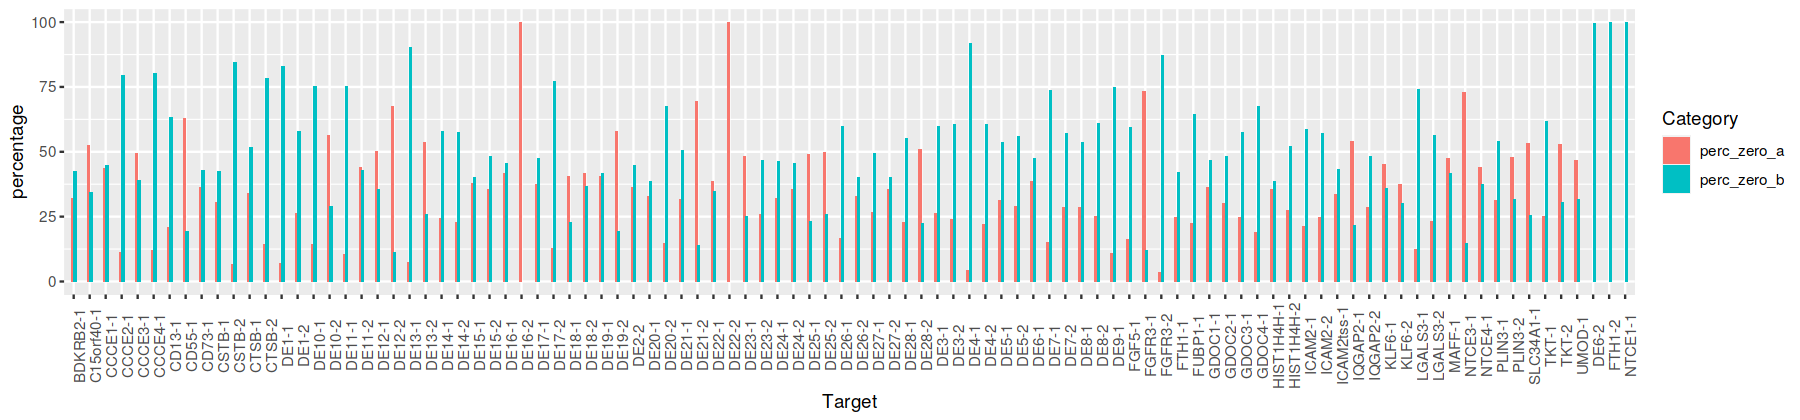

In [69]:
options(repr.plot.width=15, repr.plot.height=3.5)

ggplot(df_dummy, aes(fill=Category, y=percentage, x=Target)) +
    geom_bar(position='dodge', stat='identity', width=0.3) +
    theme(axis.text.x = element_text(angle = 90))


End debug

In [70]:
### Plot ditributions for 

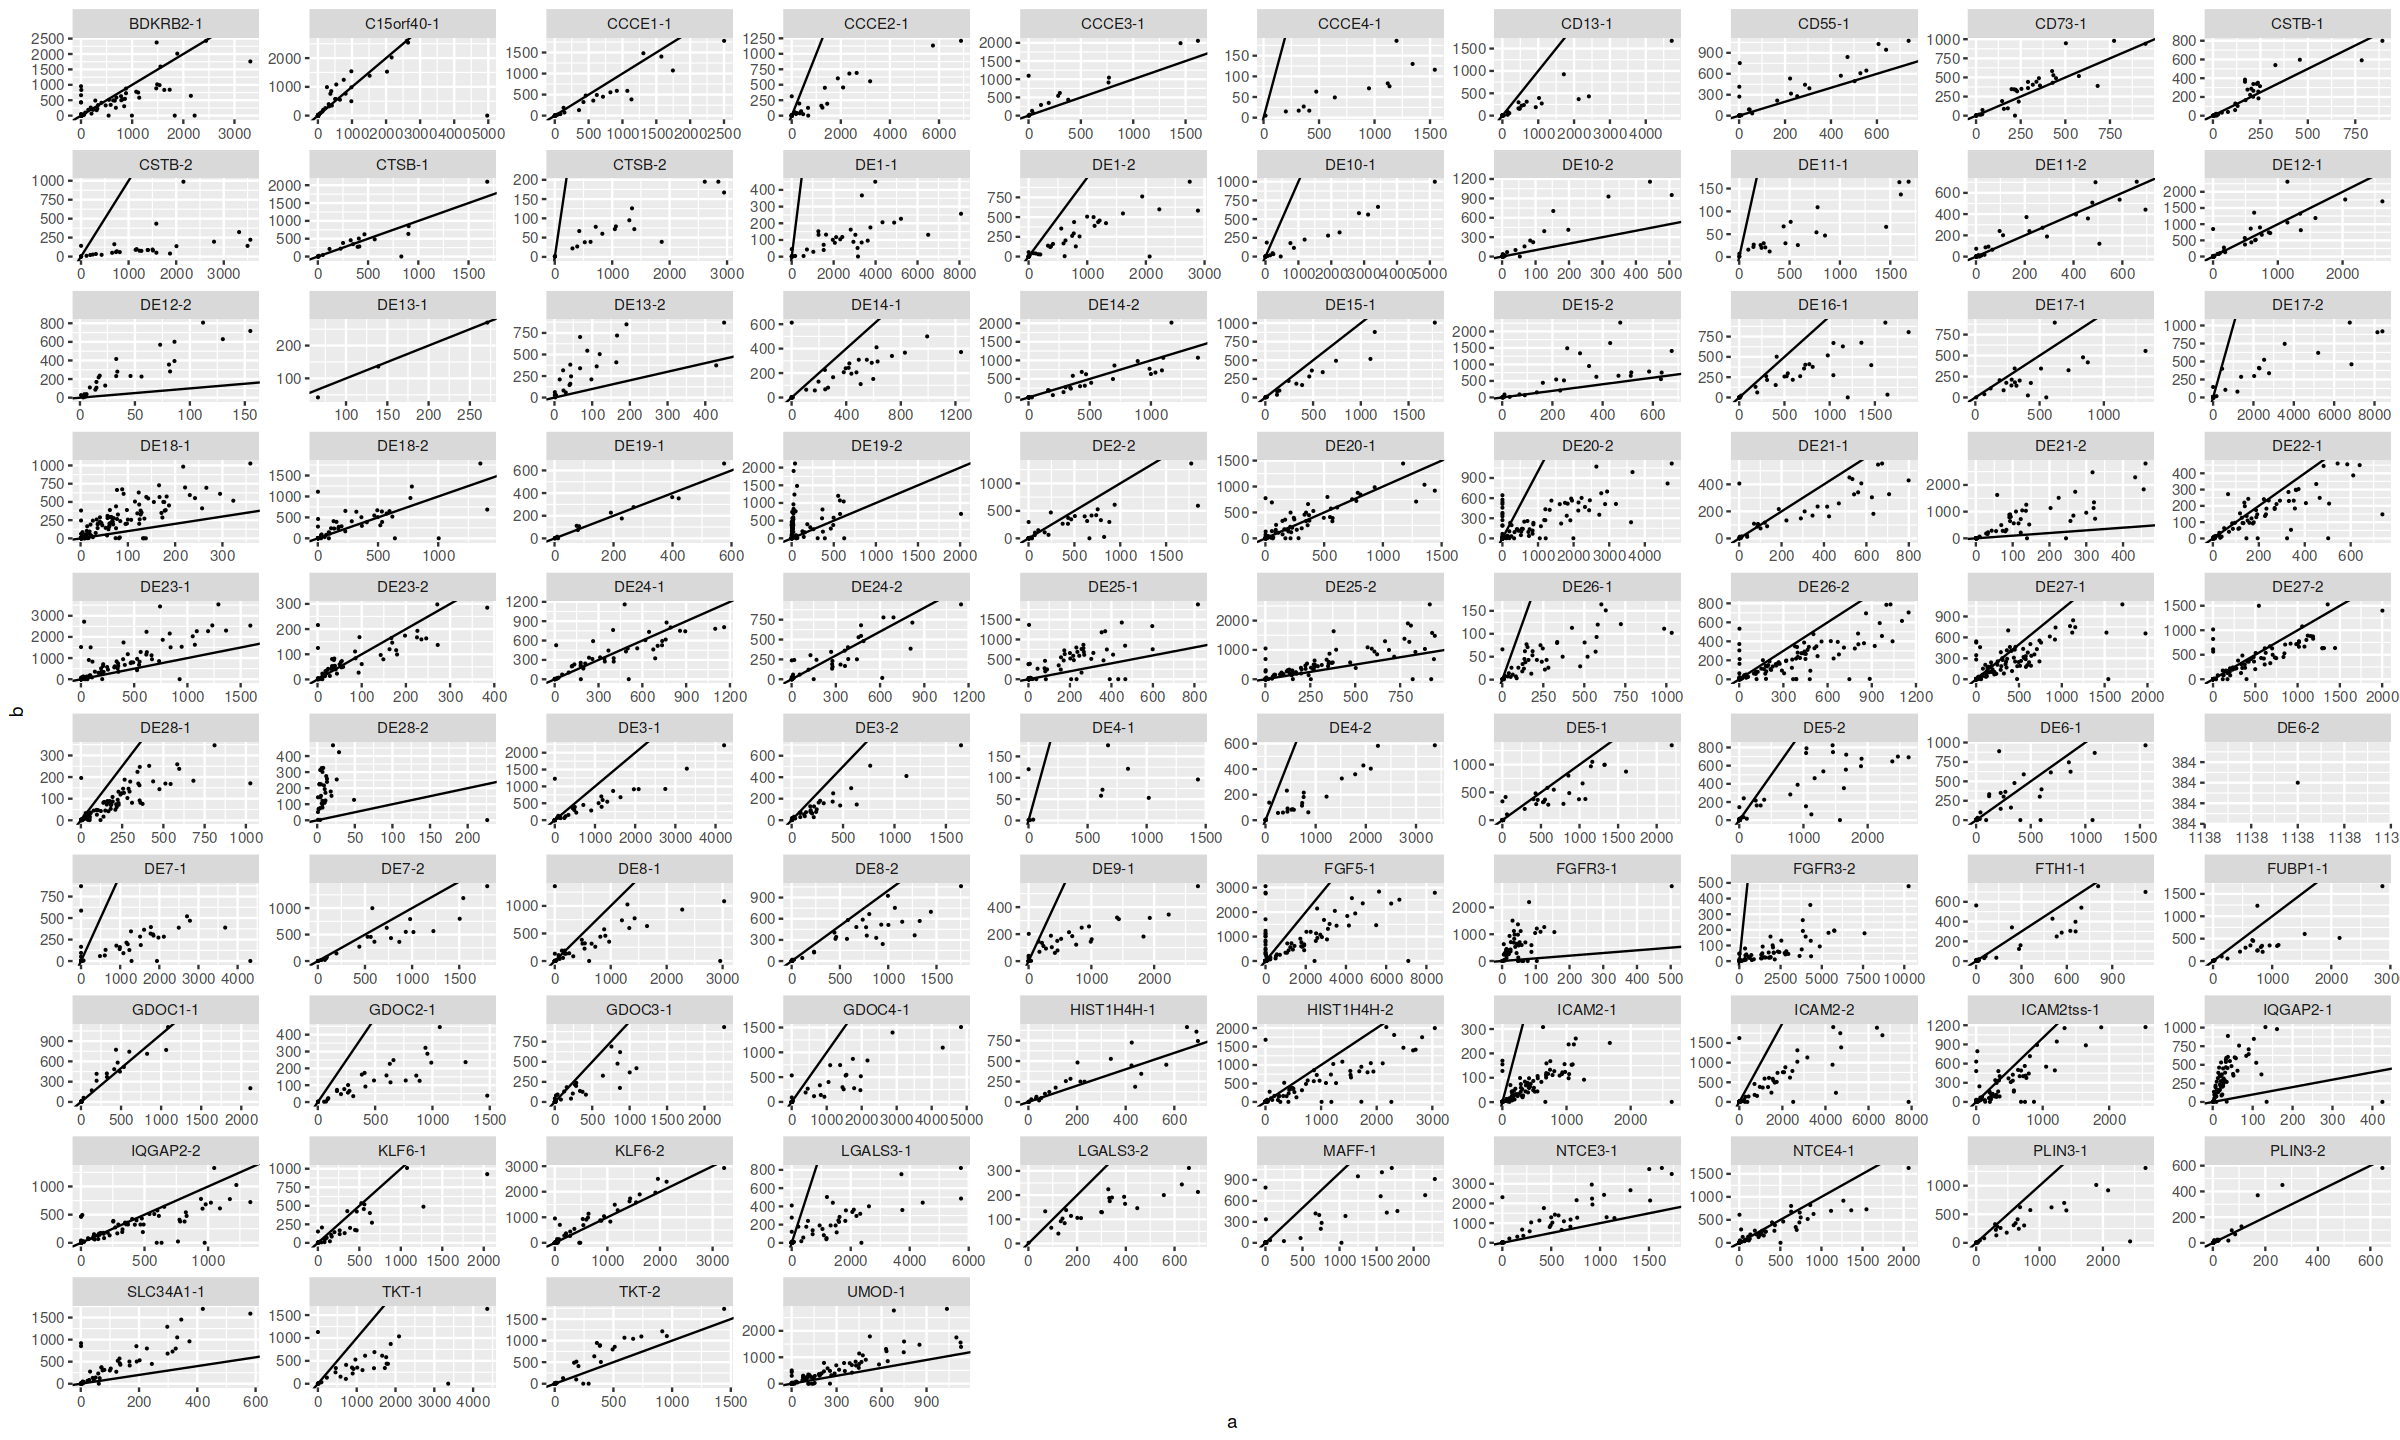

In [71]:
select_nonzero = (df_pair$a > 0) & (df_pair$b > 0)
df_pair = df_pair[select_nonzero,]

options(repr.plot.width=20, repr.plot.height=12)

p1 <- ggplot(df_pair, aes(x=a, y=b)) +
    geom_point(size=.1) +
    geom_abline(slope=1, intercept = 0) +
    facet_wrap(~ PS, scales="free", ncol = 10)

p1

### Visualize guide count distribution before demux

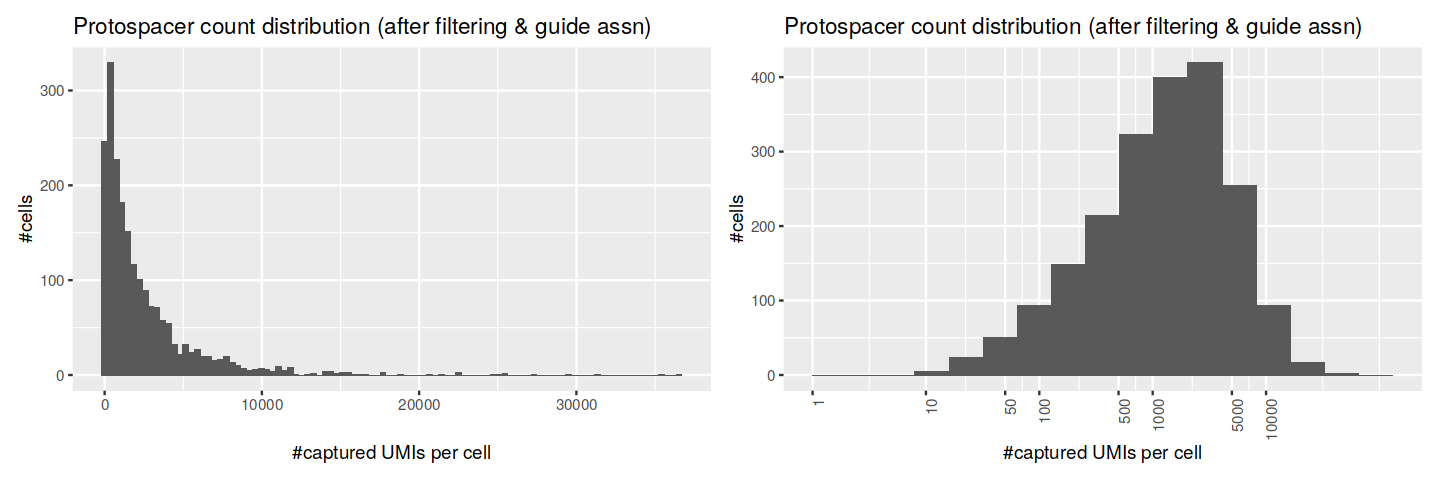

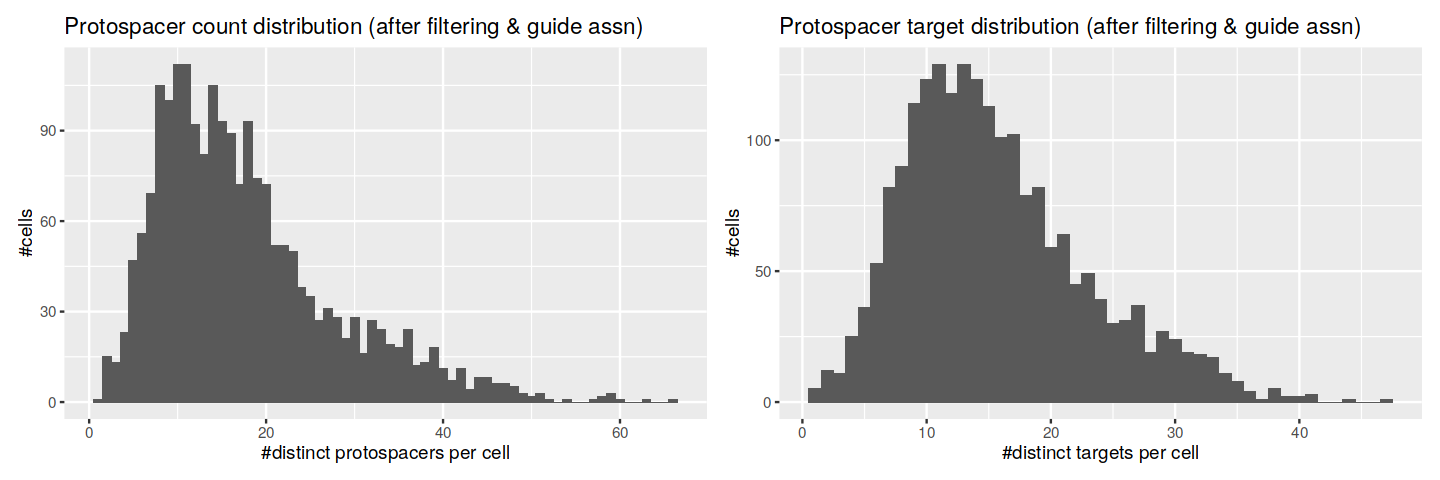

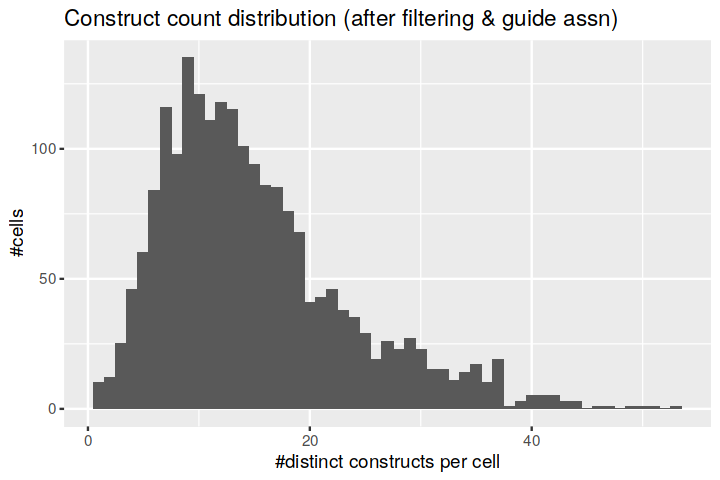

In [72]:
df_seurat <- seurat[[]]
bin_breaks <- c(1,2,2*2^(1:16))

p1 <- ggplot(df_seurat, aes(x = nCount_sgRNA)) +
    geom_histogram(bins=100) +
    labs(title = "Protospacer count distribution (after filtering & guide assn)", x = "#captured UMIs per cell") +
    labs(y = "#cells") 

p1b <- ggplot(df_seurat, aes(x = nCount_sgRNA)) +
    geom_histogram(breaks=bin_breaks) +
    scale_x_log10(breaks=c(1,10,50,100,500,1000,5000,10000)) +
    labs(title = "Protospacer count distribution (after filtering & guide assn)", x = "#captured UMIs per cell") +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(y = "#cells") 

p2 <- ggplot(df_seurat, aes(x = nFeature_sgRNA)) +
    geom_histogram(binwidth=1) +
    labs(title = "Protospacer count distribution (after filtering & guide assn)", x = "#distinct protospacers per cell") +
    labs(y = "#cells") 

p3 <- ggplot(df_guides_by_target, aes(x = total_targets)) +
    geom_histogram(binwidth=1) +
    labs(title = "Protospacer target distribution (after filtering & guide assn)", x = "#distinct targets per cell") +
    labs(y = "#cells") 


p4 <- ggplot(df_guides_by_vector, aes(x = total_vectors)) +
    geom_histogram(binwidth=1) +
    labs(title = "Construct count distribution (after filtering & guide assn)", x = "#distinct constructs per cell") +
    labs(y = "#cells") 

options(repr.plot.width=12, repr.plot.height=4)
p1 | p1b
p2 | p3
options(repr.plot.width=6, repr.plot.height=4)
p4

### Visualize guide count distribution before demux

In [73]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL
df_guide_counts$n_guides <- rowSums(df_guide_counts)

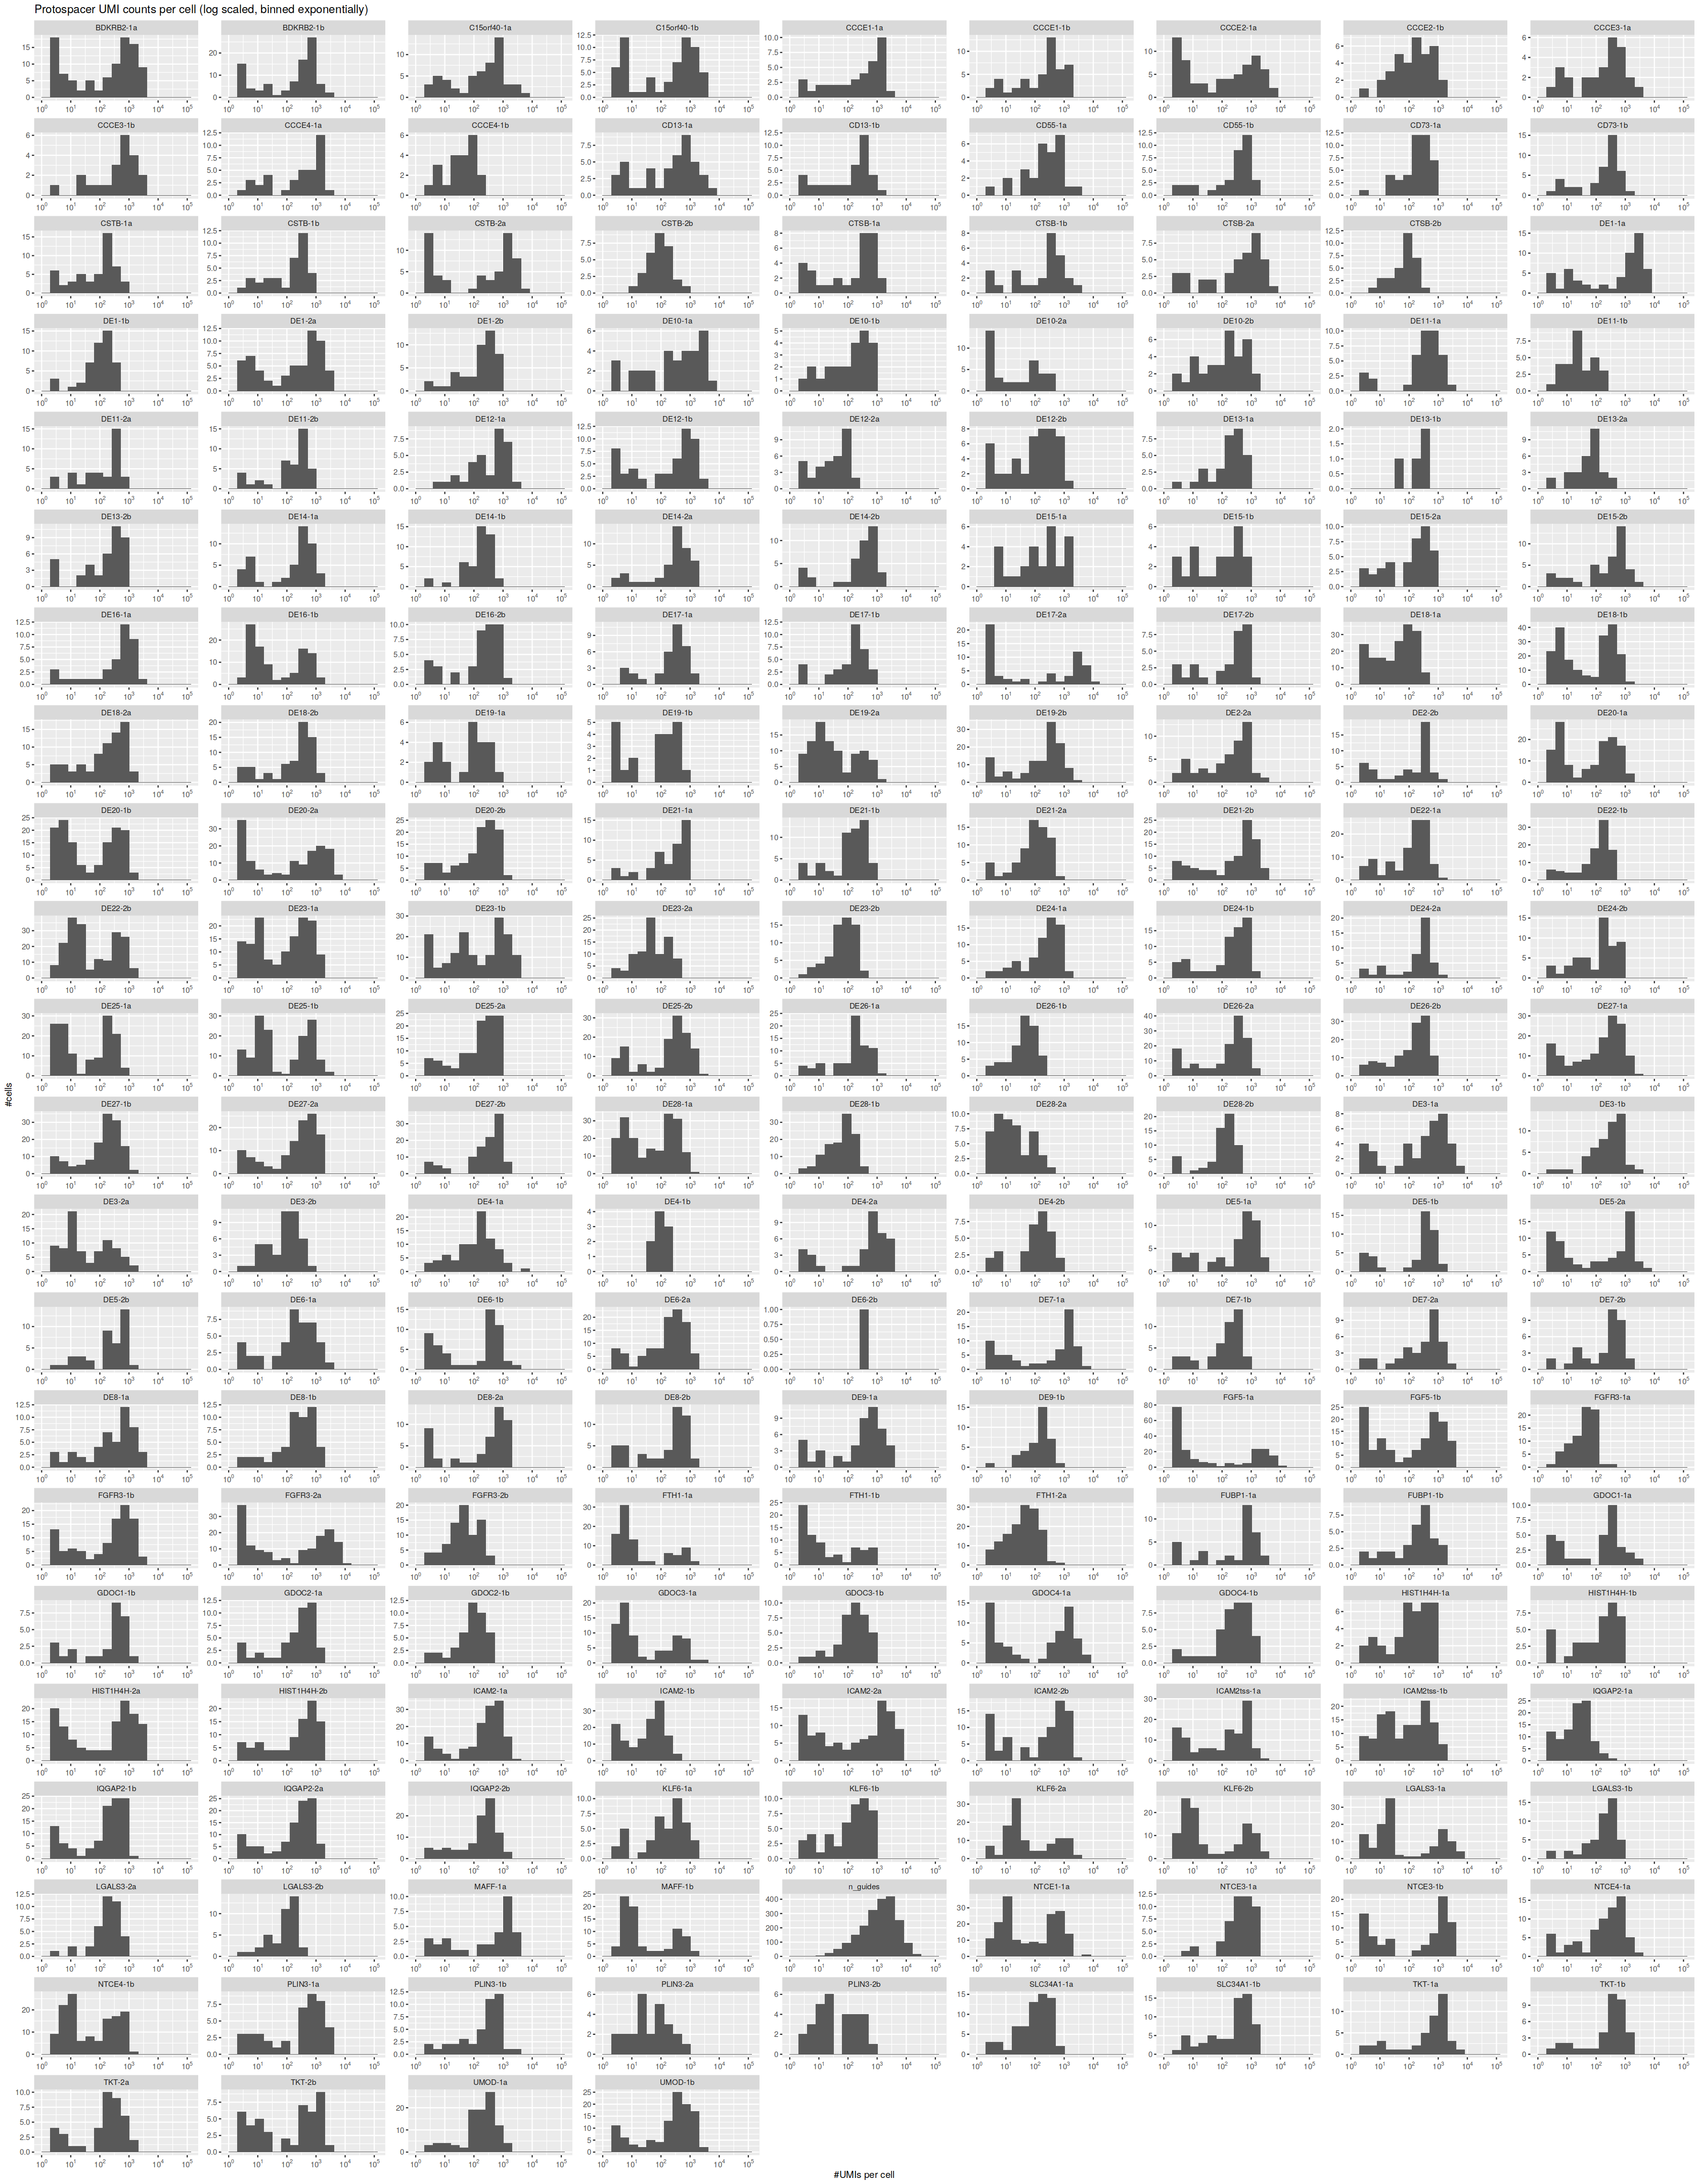

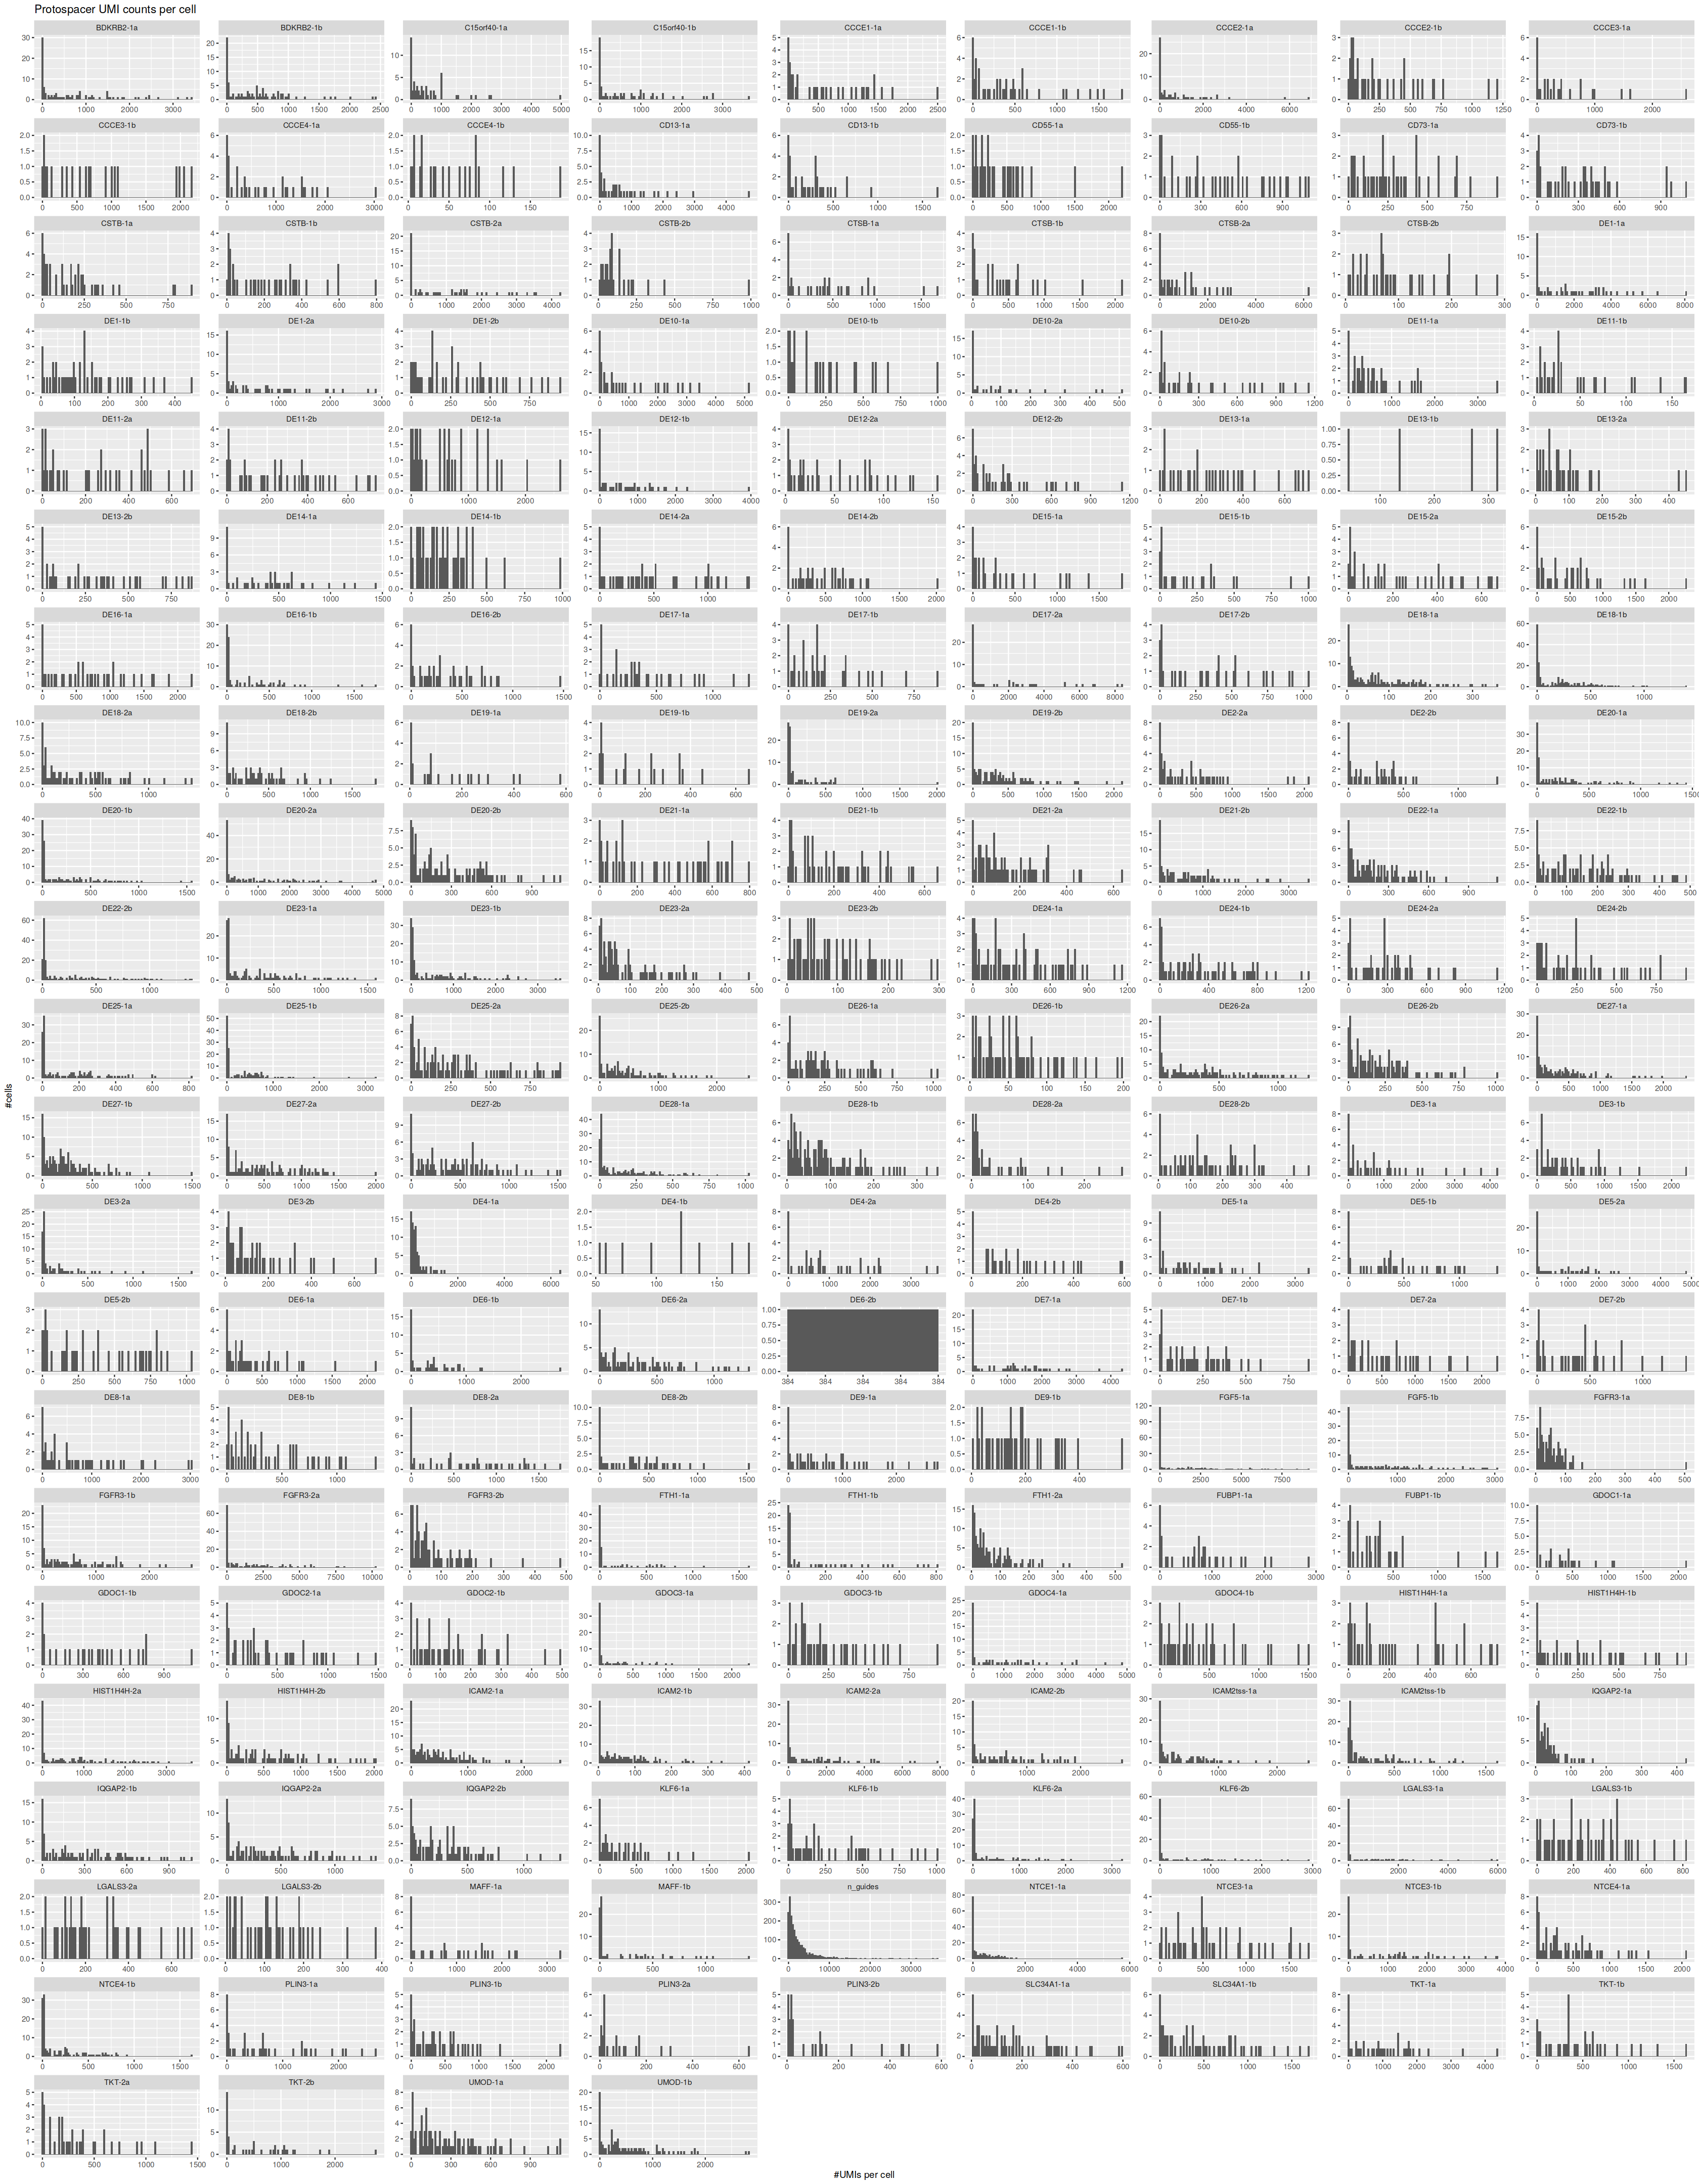

In [74]:
options(repr.plot.width=28, repr.plot.height=36)

data_long <- df_guide_counts %>%                    
  pivot_longer(colnames(df_guide_counts)) %>% 
  as.data.frame()

filter_zeros = data_long$value > 2
data_long <- data_long[filter_zeros,]
bin_breaks <- c(1,2,2*2^(1:16))

ggp1 <- ggplot(data_long, aes(x = value)) +    # Draw each column as histogram
  geom_histogram(breaks=bin_breaks) + 
  scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
  labs(title="Protospacer UMI counts per cell (log scaled, binned exponentially)", x="#UMIs per cell", y="#cells") +
  facet_wrap(~ name, scales = "free", ncol = 9)

ggp2 <- ggplot(data_long, aes(x = value)) +    # Draw each column as histogram
  geom_histogram(bins=100) + 
  labs(title="Protospacer UMI counts per cell", x="#UMIs per cell", y="#cells") +
  facet_wrap(~ name, scales = "free", ncol = 9)

ggp1
ggp2

# Plot Cellranger-demuxed counts (guide assignment)

## Plot all donors together first

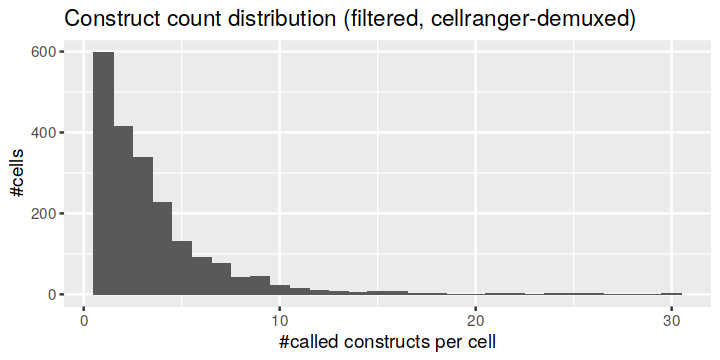

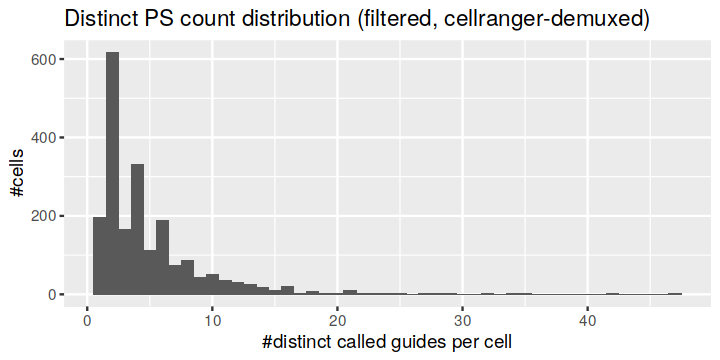

In [75]:
df_metadata = seurat@meta.data

p5 <- ggplot(df_metadata, aes(x = nCalled_Constructs)) +
    geom_histogram(binwidth=1) +
    labs(title = "Construct count distribution (filtered, cellranger-demuxed)", x = "#called constructs per cell") +
    labs(y = "#cells") 

p6 <- ggplot(df_metadata, aes(x = nPS_calls)) +
    geom_histogram(binwidth=1) +
    labs(title = "Distinct PS count distribution (filtered, cellranger-demuxed)", x = "#distinct called guides per cell") +
    labs(y = "#cells") 


options(repr.plot.width=6, repr.plot.height=3)
p5
p6

In [76]:
# library("vcd")
# filter_outliers = df_metadata$nCalled_Constructs < 20 
# n_constructs = df_metadata[filter_outliers, ]$nCalled_Constructs
# gf1 = goodfit(n_constructs, "poisson")
# rootogram(gf1, xlab = "", rect_gp = gpar(fill="chartreuse4"))

In [77]:
mean_constructs   <- round(mean(df_metadata$nCalled_Constructs),2)
median_constructs <- round(median(df_metadata$nCalled_Constructs),2)
n_guide_assigned_cells   <- nrow(df_metadata)
n_filtered_cells <- length(Cells(seurat))

n_cells_from_cellranger = ncol(rna_counts)
n_protospacers = nrow(sgrna_counts)
n_genes = nrow(rna_counts)

In [78]:
stats[["Mean distinct plasmids/cell in singlets (MOI):"]]   <- paste(mean_constructs)
stats[["Median distinct plasmids/cell in singlets (MOI):"]] <- paste(median_constructs)

In [79]:
n_cells_from_cellranger
nrow(df_metadata)

[1] 5634

[1] 2043

# Perturbation+/- counts

## Create a cell/target df

In [80]:
all_construct_calls = paste0(as.vector(seurat$construct_call), collapse="|")
all_construct_calls = strsplit(all_construct_calls, split = "\\|")
df_construct_counts = as.data.frame(table(head(all_construct_calls)))
colnames(df_construct_counts) <- c("Construct", "Count")

In [81]:
head(df_construct_counts, 2)

Construct  Count
1 BDKRB2_1   92   
2 C15orf40_1 58

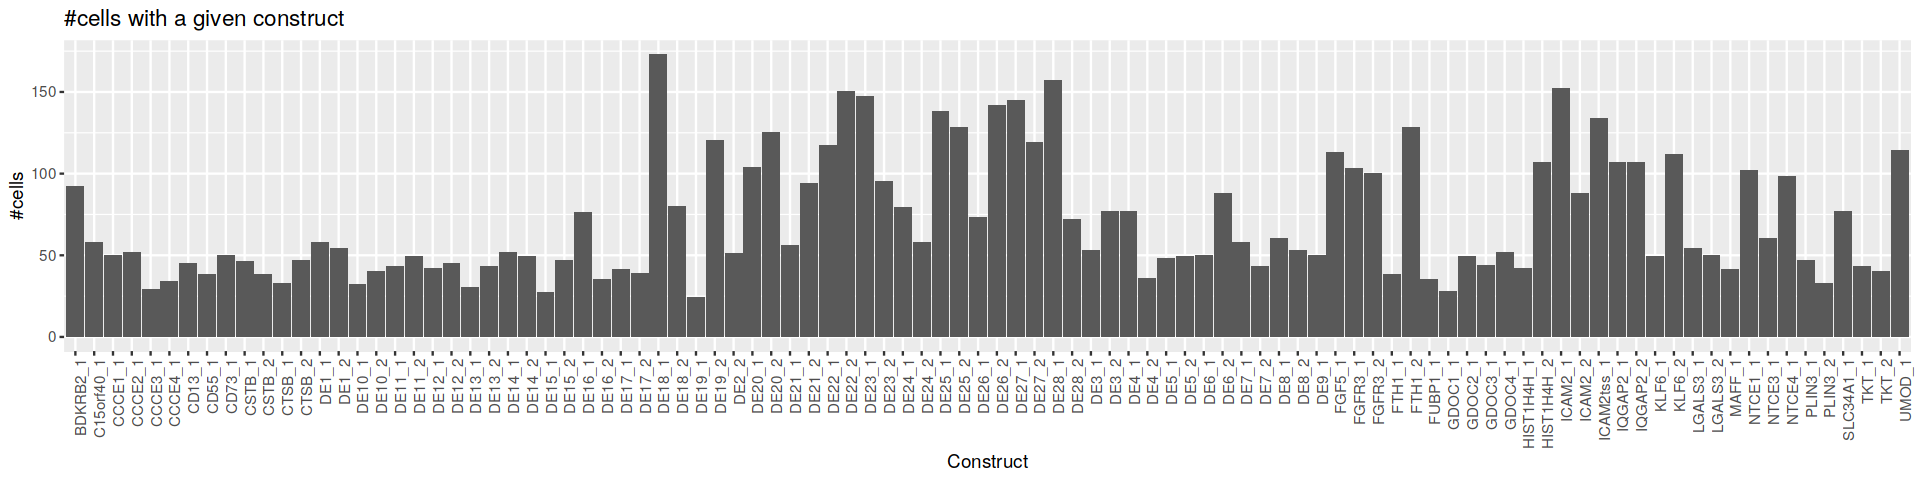

In [82]:
p6 <- ggplot(df_construct_counts, aes(x = Construct,y = Count))+
    geom_bar(stat='identity') +
    labs(title = "#cells with a given construct", x = "Construct") +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(y = "#cells") 

options(repr.plot.width=16, repr.plot.height=4)
p6

In [83]:
prefilter_vector_sums = colSums(df_guides_by_vector != 0)

In [84]:
prefilter_vector_sums[['FTH1-1']]
prefilter_vector_sums[['FTH1-2']]

[1] 234

[1] 212

# Perturbation+/- counts

## Create a cell/target df

In [85]:
targets = colnames(df_guides_by_target)
rownames(df_guides_by_target) <- rownames(as.data.frame(t(seurat[['sgRNA']]@counts)))

In [86]:
df_targets <- subset(df_guides_by_target, select=-total_targets)

In [87]:
df_targets[] <- FALSE

In [88]:
for(barcode in rownames(df_guides_by_target)){
    target_list <- as.character(seurat@meta.data[barcode, 'target_call'])
    targets = strsplit(target_list, "\\|")[[1]]
    for(target in targets) {
        df_targets[barcode, target] <- TRUE
    }
}

Double-check the target assignments

In [89]:
for(bc in rownames(df_guides_by_target)){
    eq = sum(df_targets[bc,]) == length(strsplit(as.character(seurat@meta.data[bc,'target_call']), "\\|")[[1]])
    if(!eq) { 
        print(bc)
        break
    }
}

In [90]:
colnames(df_targets)

[1] "CD13"     "CD55"     "CD73"     "FUBP1"    "C15orf40" "MAFF"    
 [7] "FTH1"     "PLIN3"    "TKT"      "LGALS3"   "CSTB"     "CTSB"    
[13] "KLF6"     "DE1"      "DE2"      "DE3"      "DE4"      "DE5"     
[19] "DE6"      "DE7"      "DE8"      "DE9"      "DE10"     "DE11"    
[25] "DE12"     "DE13"     "DE14"     "DE15"     "DE16"     "DE17"    
[31] "NTCE1"    "NTCE2"    "NTCE3"    "NTCE4"    "GDOC1"    "GDOC2"   
[37] "GDOC3"    "GDOC4"    "CCCE1"    "CCCE2"    "CCCE3"    "CCCE4"   
[43] "DE18"     "DE19"     "DE20"     "DE21"     "DE22"     "DE23"    
[49] "DE24"     "DE25"     "DE26"     "DE27"     "DE28"     "IQGAP2"  
[55] "FGFR3"    "HIST1H4H" "ICAM2"    "UMOD"     "SLC34A1"  "BDKRB2"  
[61] "ICAM2tss" "FGF5"

## Get counts for each target+/- set

In [91]:
n_cells = nrow(df_targets)
n_targets = ncol(df_targets)
df_pos_neg = data.frame(n_positives=rep(0,n_targets), n_negatives=rep(0, n_targets))
rownames(df_pos_neg) = colnames(df_targets)

for(target in colnames(df_targets)) {   
    n_pos <- sum(df_targets[, target] == TRUE)
    df_pos_neg[target, 'n_positives']  <- n_pos
    df_pos_neg[target, 'n_negatives']  <- n_cells - n_pos
    #cat(target, pos_count, neg_count, "\n")
}

select_nonzeros <- df_pos_neg[,'n_positives'] > 0
df_pos_neg <- df_pos_neg[select_nonzeros,]

In [92]:
head(df_pos_neg)

n_positives n_negatives
CD13     45          1998       
CD55     38          2005       
CD73     50          1993       
FUBP1    35          2008       
C15orf40 58          1985       
MAFF     41          2002

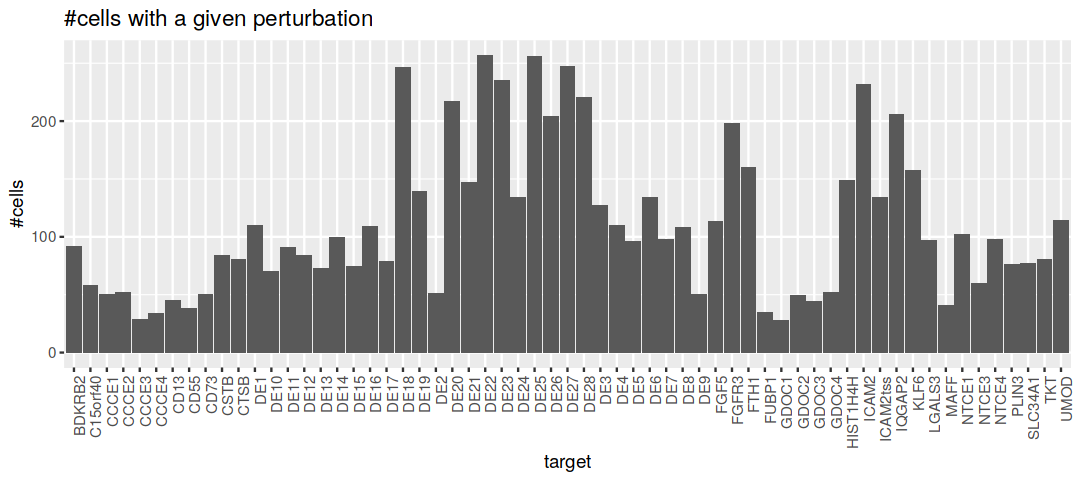

In [93]:
# Create a histogram from df_pos_neg column n_positives

p6 <- ggplot(df_pos_neg, aes(x = rownames(df_pos_neg),y = n_positives)) +
    geom_bar(stat='identity') +
    labs(title = "#cells with a given perturbation", x = "target") +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(y = "#cells") 

options(repr.plot.width=9, repr.plot.height=4)
p6


# Load Souporcell outputs

In [94]:
df_soup = read.csv(souporcell_clusters_path, sep="\t")
head(df_soup,2)

barcode            status  assignment log_prob_singleton log_prob_doublet
1 AAACCCACACGCTATA-1 singlet 0          -911               -1104           
2 AAACCCAGTCGTCGGT-1 singlet 1          -447                -526           
  cluster0 cluster1 cluster2 cluster3
1 -911     -2365    -2017    -2810   
2 -934      -447     -938    -1028

## Assign singlet/doubletstatus to Seurat cells

In [95]:
df_meta <- seurat@meta.data
df_meta$barcode <- rownames(df_meta)
df_assignment   <- subset(df_soup, select=c('barcode', 'status', 'assignment'))

df_dummy <- merge(df_meta, df_assignment, on='barcode')
nrow(df_meta)
nrow(df_dummy)

[1] 2043

[1] 2043

In [97]:
seurat$status = df_dummy$status
seurat$donor  = df_dummy$assignment

Save to Seurat H5

In [313]:
if(save_seurat_h5 == "YES") {
    print("Saving h5...")
    SaveH5Seurat(seurat, filename=save_h5_file, overwrite=TRUE, verbose=FALSE)
}

[1] "Saving h5..."


Warning message:
"Overwriting previous file /home/vsevim/prj/1012-ckd/S2//analysis/secondary/Lib_1//seurat_objects/Screen2_101vecs_Lib_1.h5seurat"
Creating h5Seurat file for version 3.1.5.9900



In [96]:
save_h5_file

[1] "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/Lib_1/seurat_objects/Screen2_101vecs_Lib_1.h5seurat"

### Eliminate doublets

How many doublets among the filtered cells? 

In [315]:
select_doublets = (df_soup$status == 'doublet')
doublet_cells   = df_soup[select_doublets,]$barcode
seurat_cells    = Cells(seurat)

select_singlets = (df_soup$status == 'singlet')
singlet_cells   = df_soup[select_singlets,]$barcode
seurat = subset(seurat, cells=singlet_cells)

stats[["Doublets in filtered cells"]] = length(intersect(doublet_cells, seurat_cells))
stats[["Total doublets before filtering"]] = length(doublet_cells)
stats[["Singlets after filtering"]] = length(Cells(seurat))
stats[["Singlets% after filtering"]] = round(length(Cells(seurat))/length(seurat_cells),1)

## Split donors, then plot

In [316]:
head(df_soup,2)

barcode            status  assignment log_prob_singleton log_prob_doublet
1 AAACCCACACGCTATA-1 singlet 0          -911               -1104           
2 AAACCCAGTCGTCGGT-1 singlet 1          -447                -526           
  cluster0 cluster1 cluster2 cluster3
1 -911     -2365    -2017    -2810   
2 -934      -447     -938    -1028

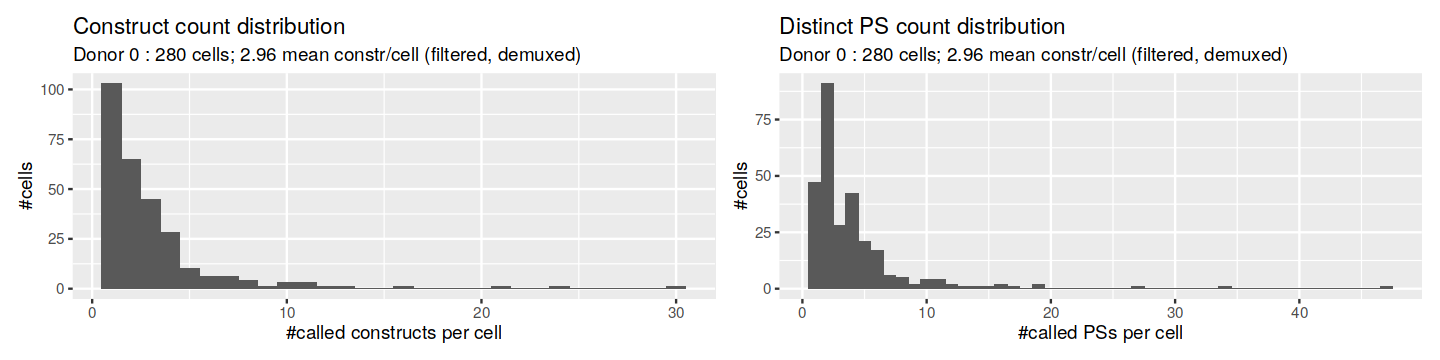

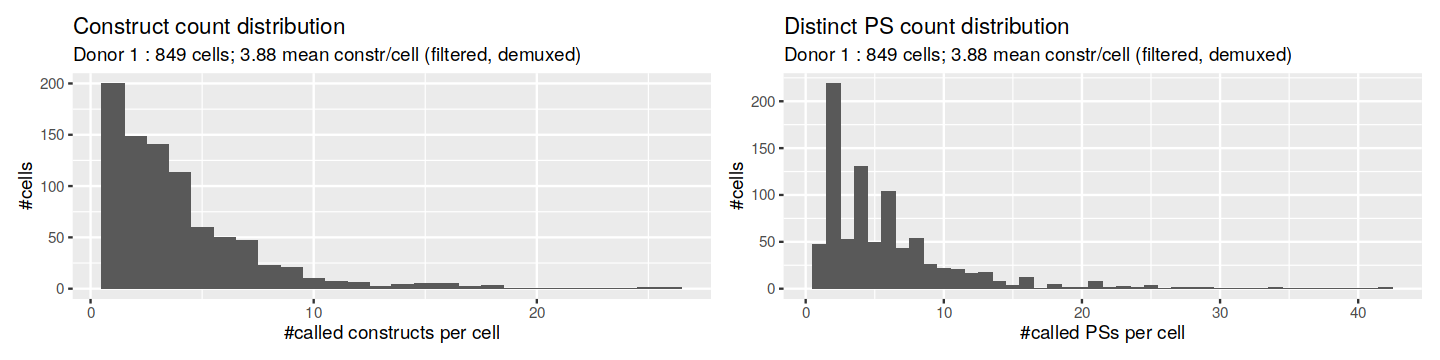

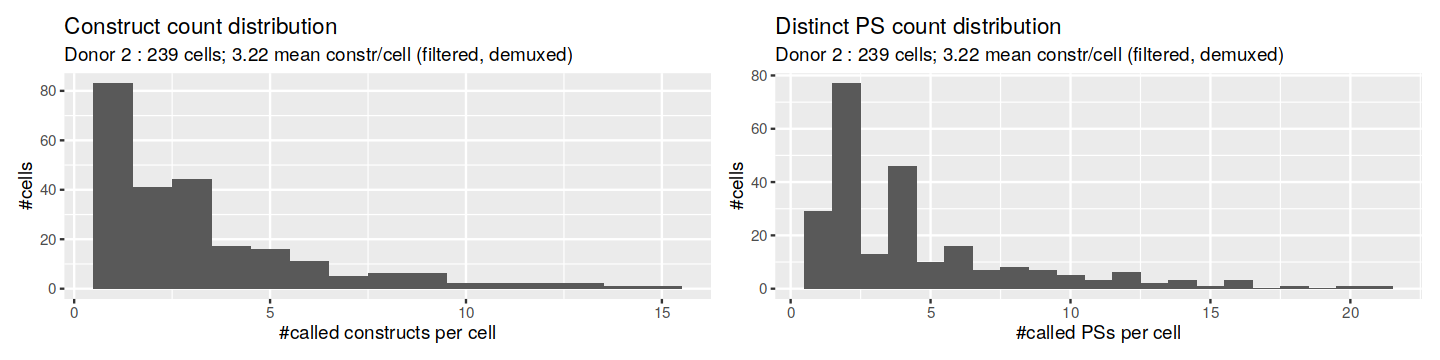

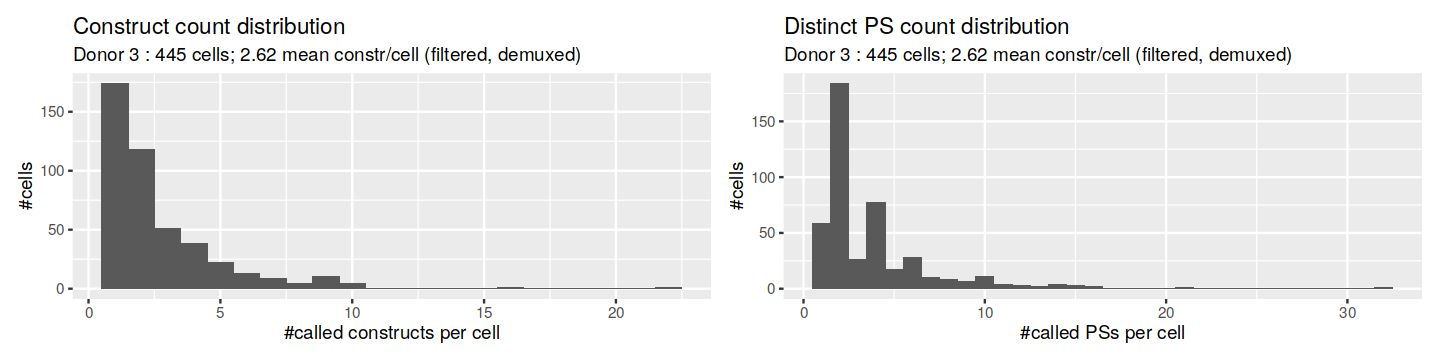

In [317]:
donors = c(0, 1, 2, 3)

for(donor_id in donors){
    select_donor = (df_soup$assignment == donor_id) & (df_soup$status == 'singlet')
    donor_cells = df_soup[select_donor,]$barcode
    seurat_donor = subset(seurat, cells = donor_cells)
    n_donor_cells = length(Cells(seurat_donor))
    df_metadata = seurat_donor@meta.data
    mean_constructs   <- round(mean(df_metadata$nCalled_Constructs),2)

    title = "Construct count distribution"
    subtitle = paste(
                    "Donor", donor_id, 
                    ":", n_donor_cells, "cells;", 
                    mean_constructs, "mean constr/cell",
                    "(filtered, demuxed)"
                )
    
    stats[[paste("Donor", donor_id, "mean constr/cell")]] = mean_constructs
    stats[[paste("Donor", donor_id, "cells" )]] = n_donor_cells

    p5 <- ggplot(df_metadata, aes(x = nCalled_Constructs)) +
        geom_histogram(binwidth=1) +
        labs(title = title, subtitle = subtitle, x = "#called constructs per cell") +
        labs(y = "#cells") 

    title = "Distinct PS count distribution "
    p6 <- ggplot(df_metadata, aes(x = nPS_calls)) +
        geom_histogram(binwidth=1) +
        labs(title = title, subtitle = subtitle, x = "#called PSs per cell") + 
        labs(y = "#cells") 

    options(repr.plot.width=12, repr.plot.height=3)
    print(p5 | p6)
    #options(repr.plot.width=6, repr.plot.height=3)
    #print(p6)
}

# Stats

In [318]:
for(stat in names(stats)){
    cat(blue(stat), ":", stats[[stat]], "\n")
}

Screen : Screen2_101vecs 
Library : Lib_1 
Cells recovered : 5634 
Genes recovered : 29924 
Protospacers in assay : 202 
Cells after QC filtering : 4498 
Cells with sgRNA count < 100 : 2590 
Cells with a guide assigned : 2043 
Mean constructs per cell (MOI): : 3.4 
Median constructs per cell (MOI): : 3 
Doublets in filtered cells : 230 
Total doublets before filtering : 407 
Singlets after filtering : 1813 
Donor 0 mean constr/cell : 3 
Donor 0 cells : 280 
Donor 1 mean constr/cell : 3.9 
Donor 1 cells : 849 
Donor 2 mean constr/cell : 3.2 
Donor 2 cells : 239 
Donor 3 mean constr/cell : 2.6 
Donor 3 cells : 445 


In [319]:
stats_fname = paste0(stats_out_path, library_name, "_stats.tsv")
dir.create(stats_out_path, showWarnings = FALSE)
write.table(stats, file=stats_fname, quote=FALSE, sep='\t', col.names = NA)

In [320]:
stats

$Screen
[1] "Screen2_101vecs"

$Library
[1] "Lib_1"

$`Cells recovered`
[1] 5634

$`Genes recovered`
[1] 29924

$`Protospacers in assay`
[1] 202

$`Cells after QC filtering`
[1] 4498

$`Cells with sgRNA count < 100`
[1] 2590

$`Cells with a guide assigned`
[1] 2043

$`Mean constructs per cell (MOI):`
[1] "3.4"

$`Median constructs per cell (MOI):`
[1] "3"

$`Doublets in filtered cells`
[1] 230

$`Total doublets before filtering`
[1] 407

$`Singlets after filtering`
[1] 1813

$`Donor 0 mean constr/cell`
[1] 3

$`Donor 0 cells`
[1] 280

$`Donor 1 mean constr/cell`
[1] 3.9

$`Donor 1 cells`
[1] 849

$`Donor 2 mean constr/cell`
[1] 3.2

$`Donor 2 cells`
[1] 239

$`Donor 3 mean constr/cell`
[1] 2.6

$`Donor 3 cells`
[1] 445

#  Clustering QC

## Is clustering driven by UMI counts?

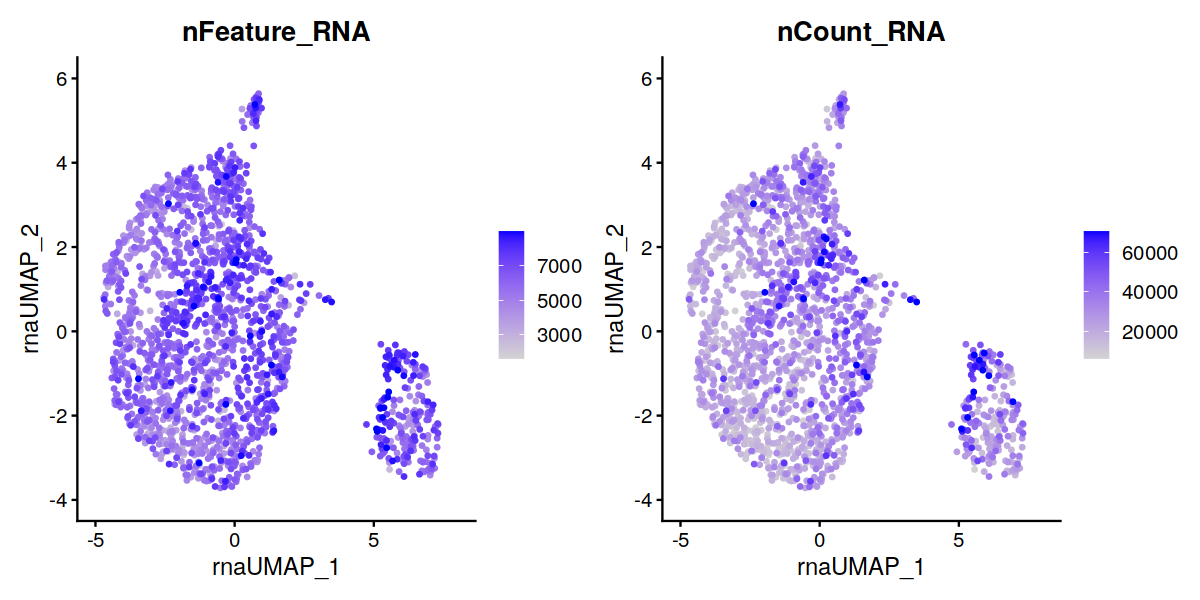

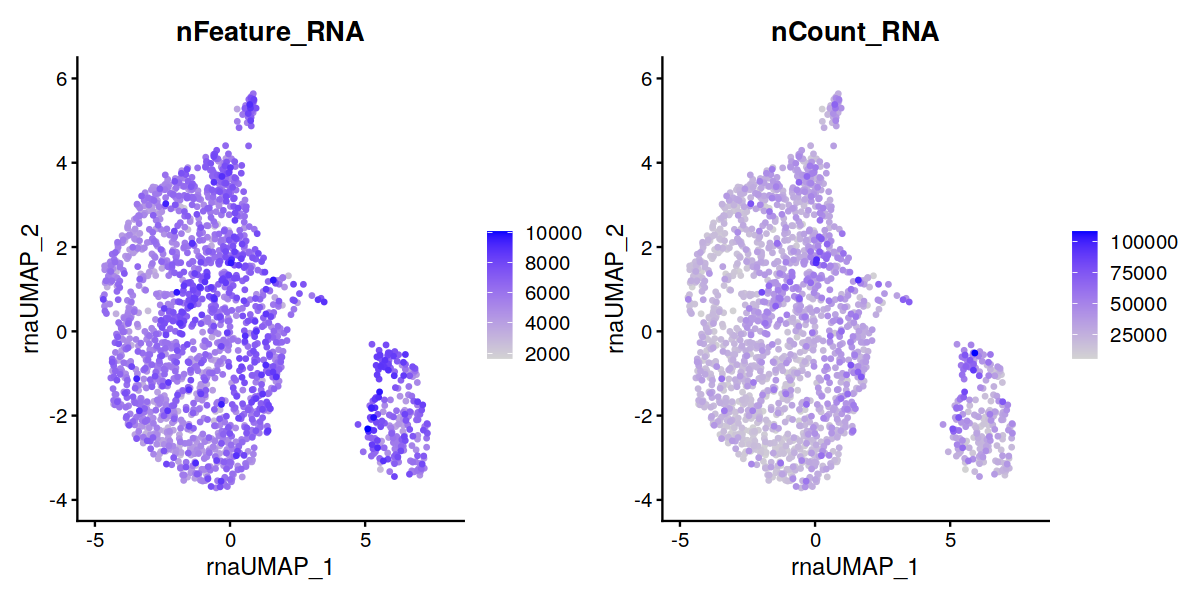

In [321]:
options(repr.plot.width=10, repr.plot.height=5)
FeaturePlot(
    seurat, 
    reduction= "umap.rna", 
    features = c("nFeature_RNA", "nCount_RNA"), 
    min.cutoff = NA, 
    max.cutoff = "q99", 
    ncol = 2, 
    order=T
)
FeaturePlot(
    seurat, 
    reduction= "umap.rna", 
    features = c("nFeature_RNA", "nCount_RNA"), 
    min.cutoff = NA, 
    max.cutoff = NA, 
    ncol = 2, 
    order=T
)

### Check if mito reads are driving the clustering

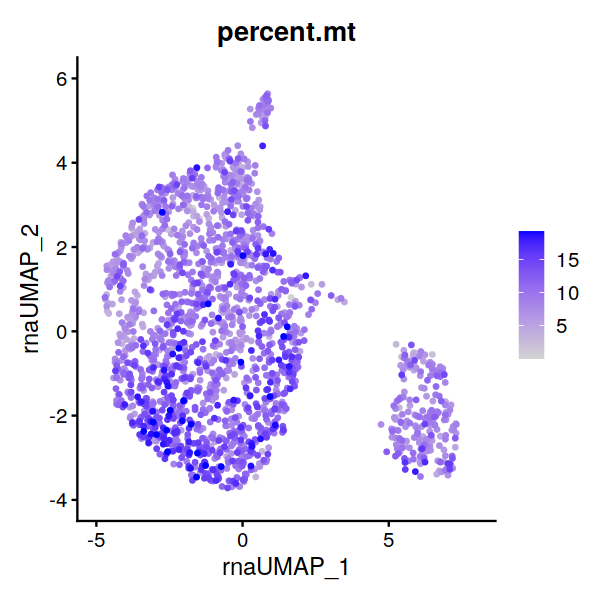

In [322]:
options(repr.plot.width=5, repr.plot.height=5)
FeaturePlot(seurat, reduction= "umap.rna", features = c("percent.mt"), min.cutoff = NA, max.cutoff = "q99", order=T)

# Stop

In [323]:
quit(save="no")

# -------

# Check the effect of the cell cycle

In [324]:
seurat <- CellCycleScoring(
    seurat, 
    s.features = s.genes, 
    g2m.features = g2m.genes, 
    set.ident = TRUE,
    assay = 'SCT'
)

Warning message:
"The following features are not present in the object: MLF1IP, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms"


ERROR: [1m[33mError[39m in `cut_number()`:[22m
[1m[22m[33m![39m Insufficient data values to produce 24 bins.


Regress out the cell cylce effects

In [ ]:
# DefaultAssay(seurat) <- "RNA"
# seurat <- SCTransform(
#     seurat, 
#     vst.flavor = "v2", 
#     verbose = FALSE, 
#     vars.to.regress = c('S.Score', 'G2M.Score')
# )  %>% 
#     RunPCA(features = c(s.genes, g2m.genes)) %>% 
#     RunUMAP(dims = 1:40, reduction.name = 'umap.rna', reduction.key = 'rnaUMAP_', verbose=FALSE)

Alternatively use this

In [ ]:
#seurat <- RunPCA(seurat, features = c(s.genes, g2m.genes))

Picking joint bandwidth of 0.126

Picking joint bandwidth of 0.163

Picking joint bandwidth of 0.0804

Picking joint bandwidth of 0.114



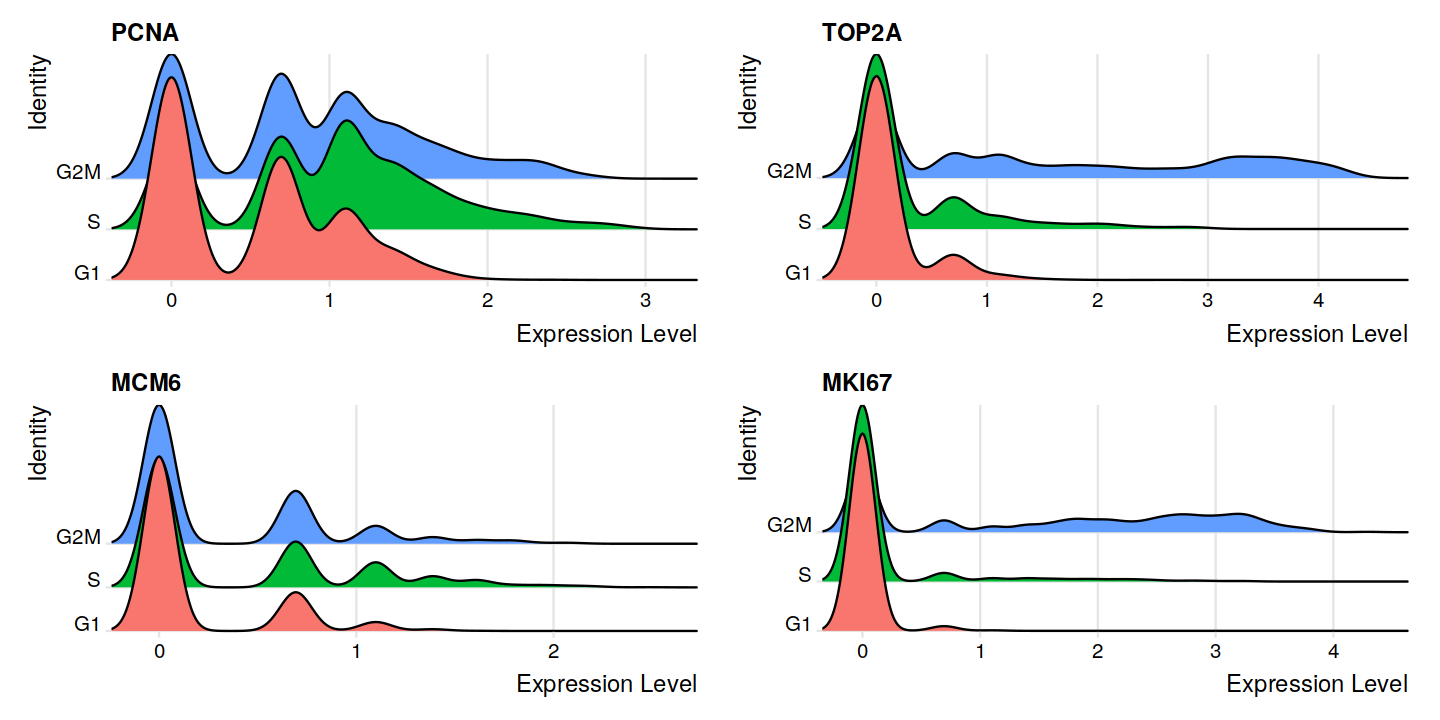

In [ ]:
# Visualize the distribution of cell cycle markers across
options(repr.plot.width=12, repr.plot.height=6)
DefaultAssay(seurat) <- "SCT"
RidgePlot(seurat, features = c("PCNA", "TOP2A", "MCM6", "MKI67"), ncol = 2)

In [ ]:
length(s.genes)
length(g2m.genes)

[1] 43

[1] 54

In [ ]:
options(repr.plot.width=11, repr.plot.height=5)
FeaturePlot(
    seurat, 
    reduction= "umap.rna", 
    features = c("S.Score", "G2M.Score"), 
    min.cutoff = NA, 
    max.cutoff = NA, 
    ncol = 2, 
    order=T
)

Warning message in FetchData.Seurat(object = object, vars = c(dims, "ident", features), :
"The following requested variables were not found: S.Score, G2M.Score"


ERROR: Error: None of the requested features were found: S.Score, G2M.Score in slot data


Warning message in PrepDR(object = object, features = features, verbose = verbose):
"The following 29 features requested have not been scaled (running reduction without them): MCM5, FEN1, MCM2, UNG, MCM6, CDCA7, PRIM1, MLF1IP, RFC2, RPA2, SLBP, UBR7, MSH2, RAD51, CDC45, EXO1, TIPIN, DSCC1, CASP8AP2, CHAF1B, FAM64A, HN1, RANGAP1, NCAPD2, PSRC1, CKAP5, CTCF, G2E3, CBX5"
PC_ 1 
Positive:  CENPF, MKI67, TOP2A, HMGB2, TPX2, DLGAP5, NUSAP1, ANLN, HMMR, GTSE1 
	   BIRC5, CENPE, CKS2, CDK1, KIF20B, CDC20, UBE2C, RRM2, HJURP, SMC4 
	   AURKA, NUF2, TACC3, TUBB4B, KIF11, KIF2C, KIF23, CCNB2, CDCA2, NDC80 
Negative:  POLD3, POLA1, CCNE2, GAS2L3, CDC6, WDR76, UHRF1, LBR, PCNA, USP1 
	   GMNN, DTL, BLM, MCM4, CENPA, GINS2, E2F8, BRIP1, RRM1, ANP32E 
	   HELLS, CDC25C, ECT2, NASP, RAD51AP1, ATAD2, CKAP2, CDCA3, AURKB, TYMS 
PC_ 2 
Positive:  CKS2, DLGAP5, HMMR, CDC20, AURKA, CCNB2, NEK2, BIRC5, CDCA3, TPX2 
	   CENPA, GTSE1, KIF20B, CENPE, NUSAP1, UBE2C, CKAP2, BUB1, NUF2, CENPF 
	   TUBB4B, KIF23, 

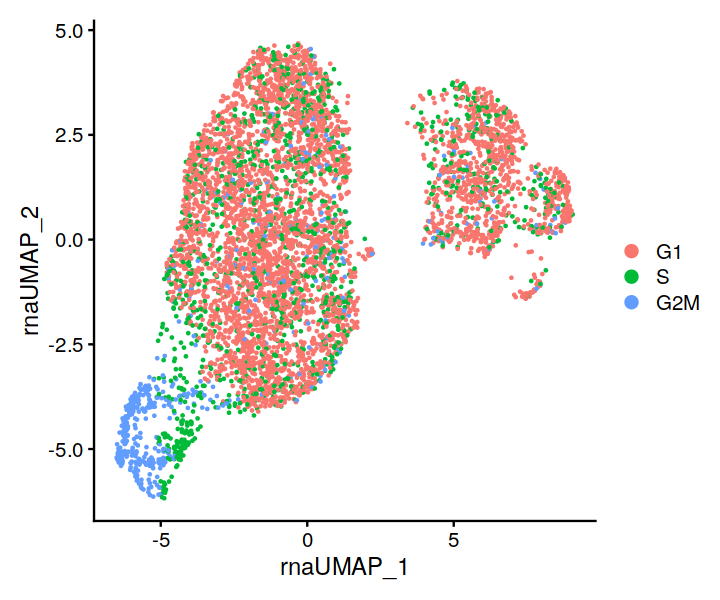

In [ ]:
DefaultAssay(seurat) <- "SCT"
seurat_new <- RunPCA(seurat, npcs = 20, features = c(s.genes, g2m.genes))
options(repr.plot.width=6, repr.plot.height=5)
DimPlot(seurat)

# Regress out %mito, #UMIs, S Score

In [ ]:
seurat_new <- SCTransform(
  seurat_new,
  assay = 'RNA',
  new.assay.name = 'SCT',
  vars.to.regress = c('percent.mt', 'nFeature_RNA', 'nCount_RNA', 'S.Score', 'G2M.Score'),
  verbose = FALSE,
) %>% RunPCA() %>% RunUMAP(
        dims = 1:40,
        reduction.name = 'umap.rna',
        reduction.key = 'rnaUMAP_',
        verbose=FALSE
      )

PC_ 1 
Positive:  ERBB4, KCNIP4, MECOM, WFDC2, FAM155A, MAL, BST2, AC019197.1, PDE1A, SFRP1 
	   KITLG, SKAP1, TFAP2B, ACSL4, SNED1, S100A2, GPNMB, PKHD1, TFCP2L1, DENND2A 
	   KRT19, PANTR1, SGIP1, SIM1, LRP1B, CSGALNACT1, ARHGEF38, HOXB3, SCN2A, SIM2 
Negative:  APOE, FTL, FN1, CRYAB, SOD2, MT1X, CDH6, S100A1, PLIN2, G0S2 
	   SERPINE1, VCAM1, VGF, RHEX, MT1E, CTSB, RARRES2, TFPI2, MGST1, FGB 
	   SERPINA1, ABLIM3, GPX3, SLC2A9, NRXN3, IL32, RRAD, NUPR1, AKR1C3, GPC6 
PC_ 2 
Positive:  FKBP5, MALAT1, APOE, MDM2, SERPINA1, KCNIP4, GBE1, NEAT1, ADAMTS9-AS2, FTL 
	   LINC01515, MT1X, LINC01320, SOD2, PKP4, ZNF385B, ZIM3, RRAD, FNIP2, MSC-AS1 
	   PLIN2, PDE4D, SSBP2, CPD, FTH1, DLEU2, ACSM2A, KLF9, NRXN3, ABLIM3 
Negative:  KRT19, PLAU, PLCB4, TUBA1A, CCND1, ADIRF, TMSB10, AKAP12, LGALS1, DCBLD2 
	   S100A6, ARHGAP29, CASC19, C12orf75, AL355916.1, TPM1, ARL4C, TUBA1B, KRT18, ACTB 
	   MT1E, AC078923.1, THBS1, ANGPTL4, TMSB4X, AHNAK, HMGA2, VIM, CCN1, FRMD5 
PC_ 3 
Positive:  FTL, PLIN2,

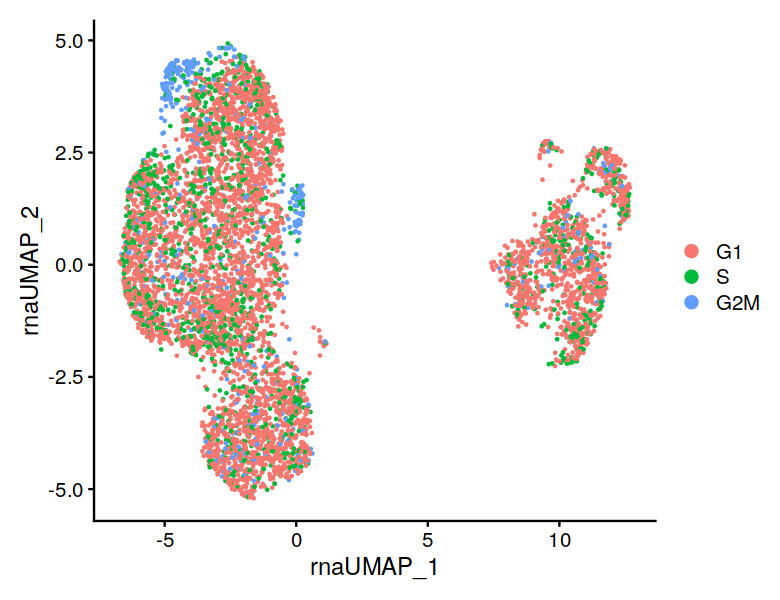

In [ ]:
options(repr.plot.width=6.5, repr.plot.height=5)
DimPlot(seurat_new)

## Debug

In [ ]:
donor_id = 1
select_donor = (df_soup$assignment == donor_id) & (df_soup$status == 'singlet')
donor_cells = df_soup[select_donor,]$barcode

In [ ]:
length(donor_cells)

[1] 2819

In [ ]:
head(df_soup)

barcode            status  assignment log_prob_singleton log_prob_doublet
1 AAACCCAAGAGCAGCT-1 singlet 3           -695               -837           
2 AAACCCAAGCCGGAAT-1 doublet 1/2        -6694              -4669           
3 AAACCCAAGCTTAAGA-1 singlet 0          -1141              -1789           
4 AAACCCAAGGCTGTAG-1 singlet 0          -1577              -2450           
5 AAACCCAAGGTTTACC-1 singlet 2          -1469              -1764           
6 AAACCCAAGTGATCGG-1 singlet 2           -677               -795           
  cluster0 cluster1 cluster2 cluster3
1 -2104    -2279    -2433      -695  
2 -8876    -6694    -6876    -11522  
3 -1141    -3152    -2890     -3469  
4 -1577    -4912    -3989     -5245  
5 -3908    -4682    -1469     -5438  
6 -1757    -2186     -677     -2490

# Visualize RNA count distribution

In [ ]:
DefaultAssay(seurat) <- "SCT"
top_genes <- sample(VariableFeatures(seurat), 80)
DefaultAssay(seurat) <- "RNA"
df_rna_counts <- as.data.frame(t(seurat[['RNA']]@counts[top_genes, ]))
rownames(df_rna_counts) <- NULL
df_rna_counts$n_rna <- rowSums(df_rna_counts)

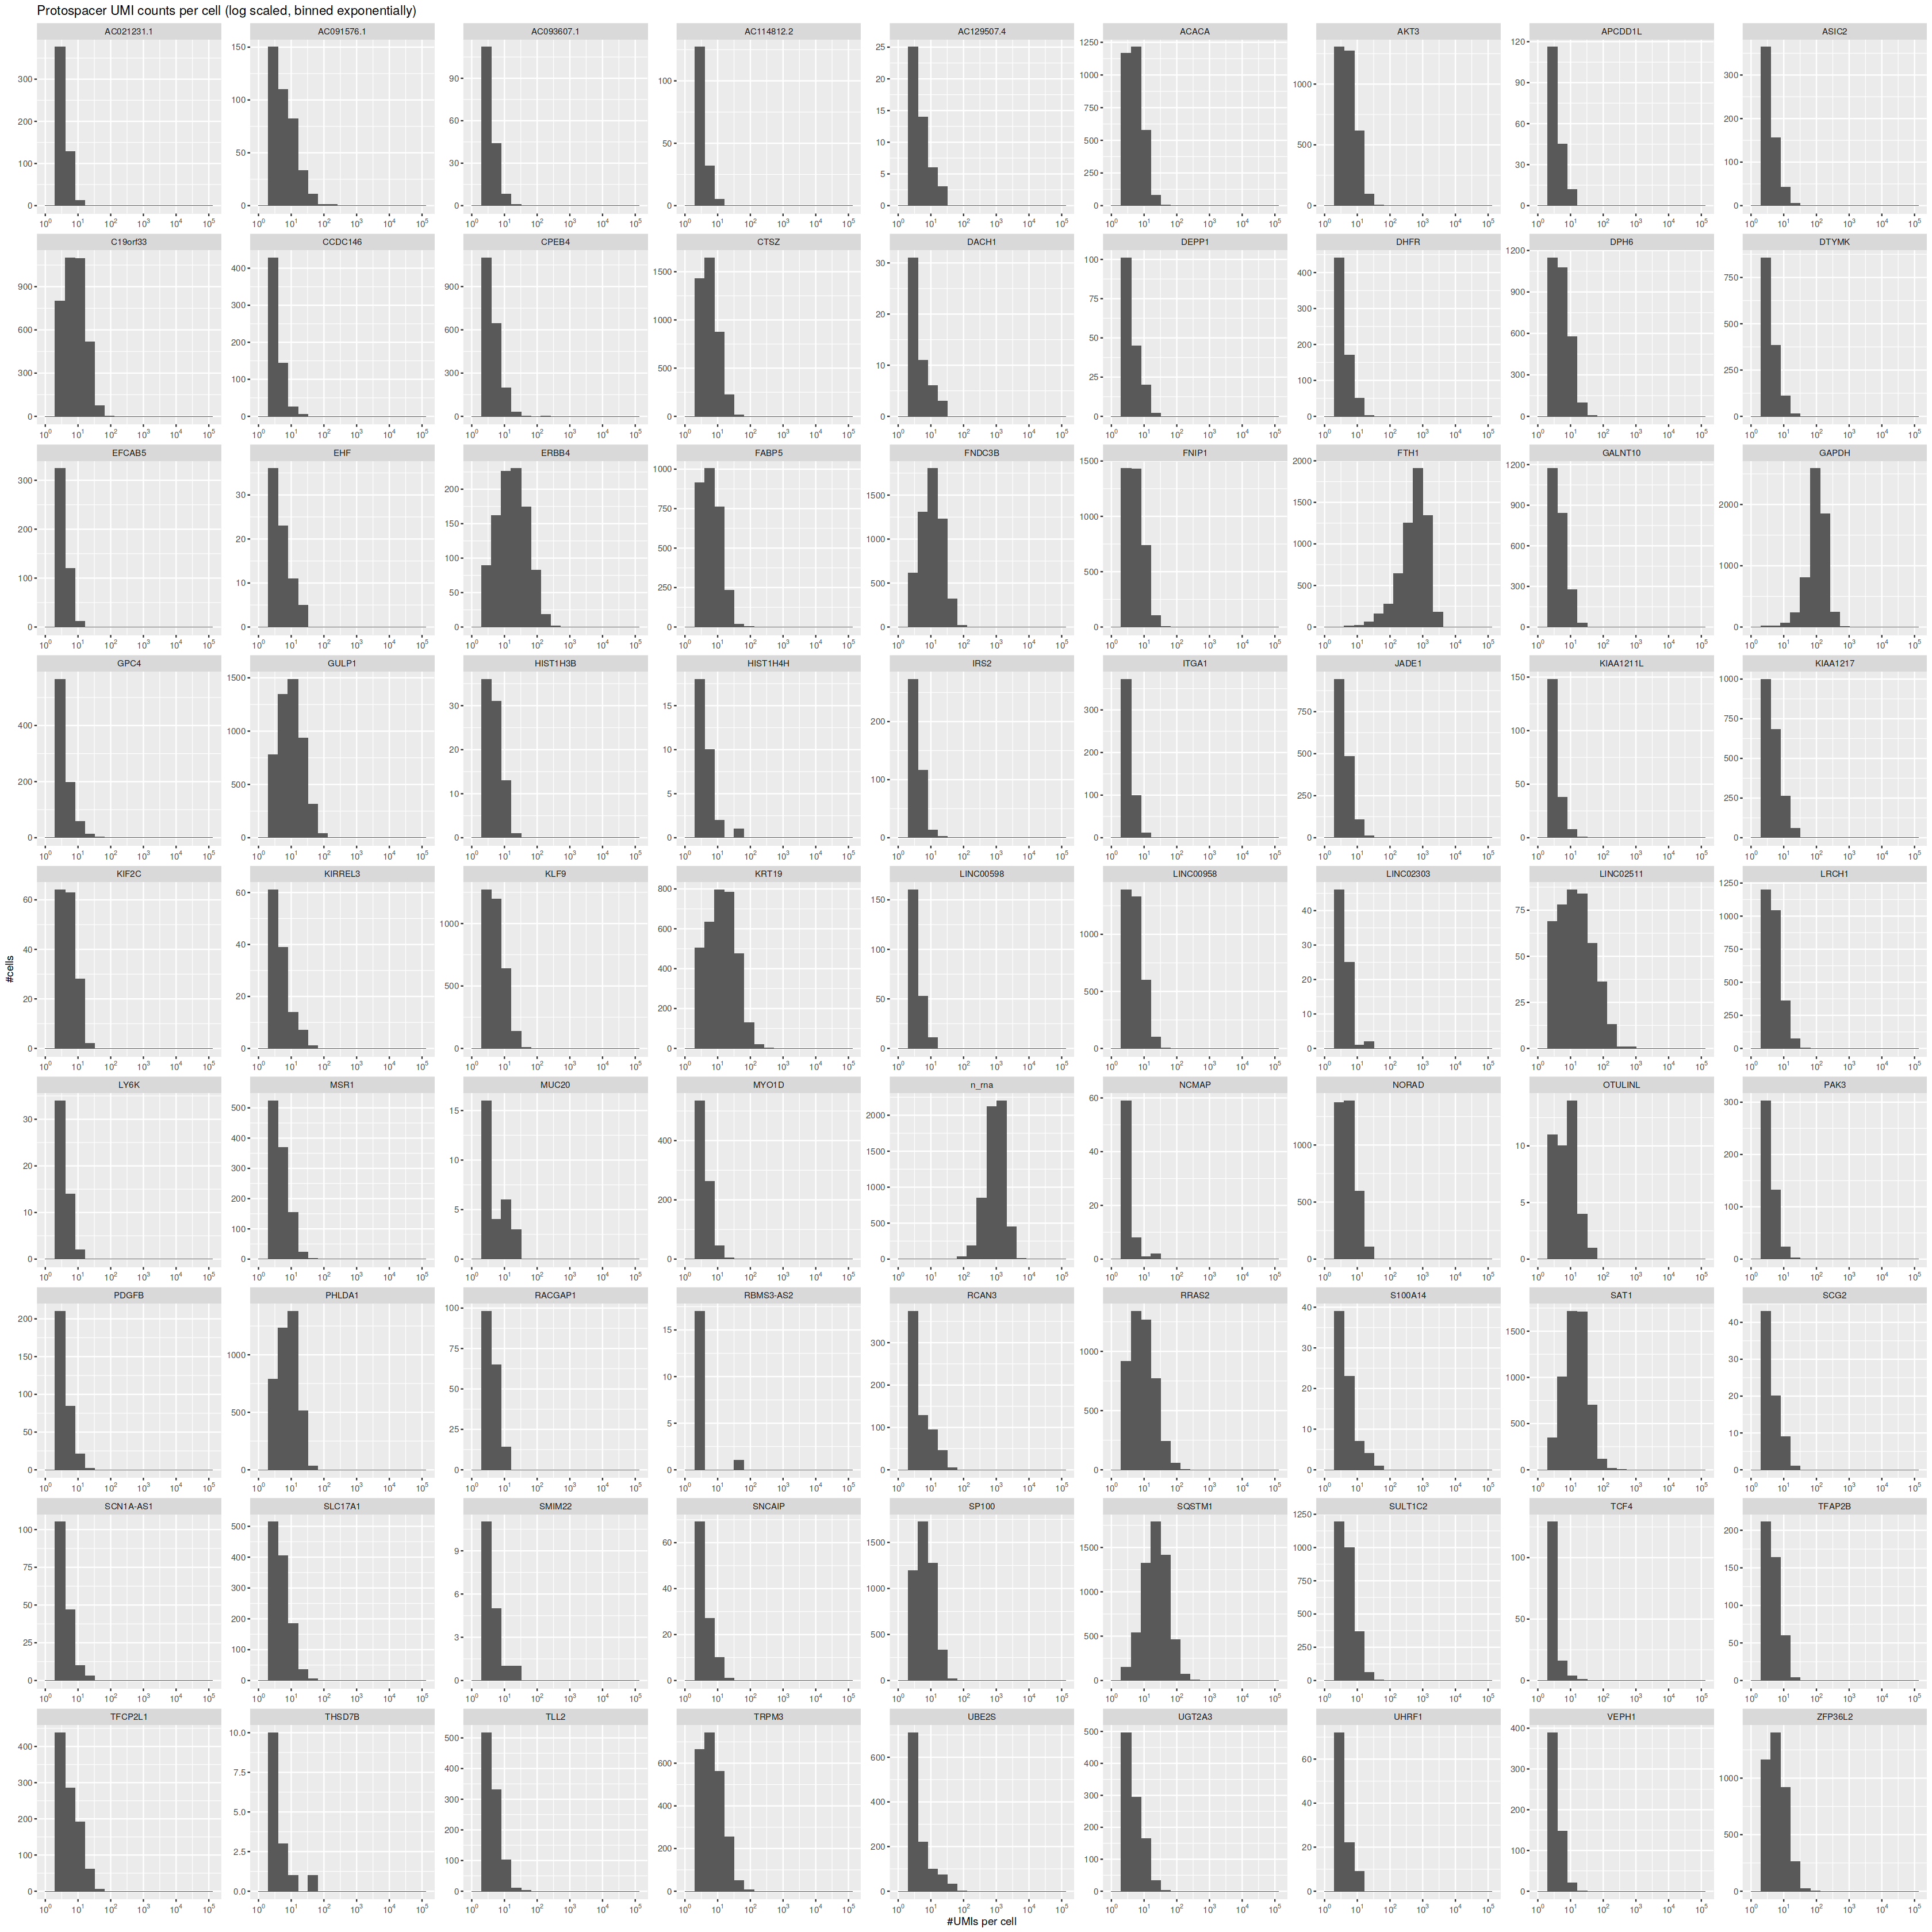

In [ ]:
options(repr.plot.width=28, repr.plot.height=20)

data_long <- df_rna_counts %>%                    
  pivot_longer(colnames(df_rna_counts)) %>% 
  as.data.frame()

filter_zeros = data_long$value > 2
data_long <- data_long[filter_zeros,]
bin_breaks <- c(1,2,2*2^(1:16))

ggp1 <- ggplot(data_long, aes(x = value)) +    # Draw each column as histogram
  geom_histogram(breaks=bin_breaks) + 
  scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
  labs(title="Protospacer UMI counts per cell (log scaled, binned exponentially)", x="#UMIs per cell", y="#cells") +
  facet_wrap(~ name, scales = "free", ncol = 9)

ggp2 <- ggplot(data_long, aes(x = value)) +    # Draw each column as histogram
  geom_histogram(bins=100) + 
  labs(title="Protospacer UMI counts per cell", x="#UMIs per cell", y="#cells") +
  facet_wrap(~ name, scales = "free", ncol = 9)


options(repr.plot.width=28, repr.plot.height=28)
ggp1
#ggp2